# This notebook is created to participate in Zelestra Hackathon
## Instructions:
### As solar energy systems become increasingly popular in sustainable energy infrastructures, maintaining high performance and reducing downtime are essential. Traditional maintenance methods for photovoltaic (PV) systems are often reactive, leading to energy loss and increased costs. The goal of this project is to develop a Machine Learning model that predicts performance degradation and potential failures in solar panels.

###**Task**

### You are tasked to develop a Machine Learning model that predicts performance degradation and potential failures in solar panels using historical and real-time sensor data, enabling predictive maintenance and optimal energy output.
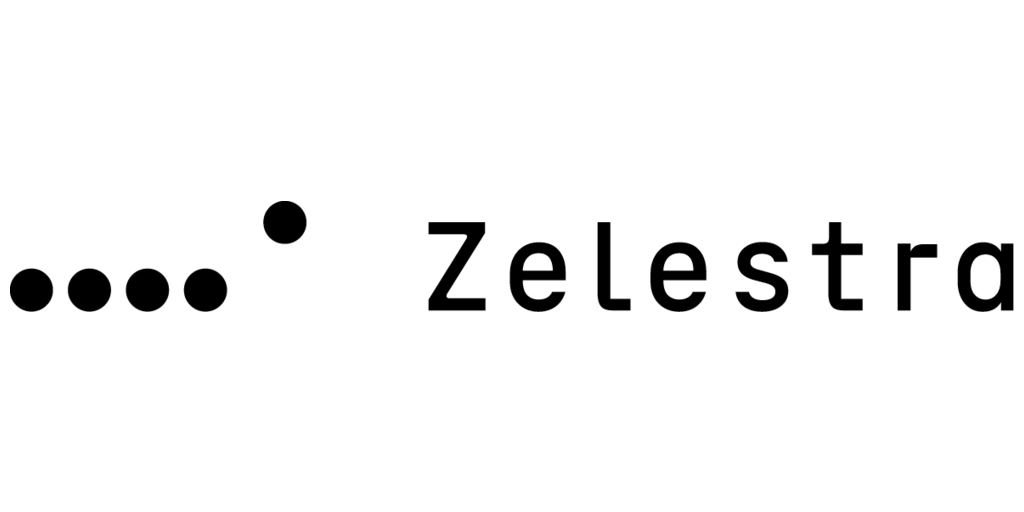

# Import libraries

In [50]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.9 MB/s eta 0:00:00


In [55]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.5 MB/s eta 0:00:00


In [65]:
pip install pytorch_tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 975.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [66]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

import optuna
import lightgbm as lgb
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# 1. Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# File paths to training and testing data
file_path_train = '/content/drive/MyDrive/Zelestra/dataset/train.csv'
file_path_test = '/content/drive/MyDrive/Zelestra/dataset/test.csv'

train = pd.read_csv(file_path_train)
test = pd.read_csv(file_path_test)

In [4]:
train.head()

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,string_id,error_code,installation_type,efficiency
0,0,7.817315,576.179270,41.24308670850264,32.135501,4.0,0.803199,37.403527,1.963787,13.691147,62.494044,12.82491203459621,1018.8665053152533,A1,NaN,NaN,0.562096
1,1,24.785727,240.003973,1.3596482765960705,19.977460,8.0,0.479456,21.843315,0.241473,27.545096,43.851238,12.012043660984917,1025.6238537572883,D4,E00,dual-axis,0.396447
2,2,46.652695,687.612799,91.26536837560256,1.496401,4.0,0.822398,48.222882,4.191800,43.363708,NaN,1.814399755560454,1010.9226539809573,C3,E00,NaN,0.573776
3,3,53.339567,735.141179,96.19095521176159,18.491582,3.0,0.837529,46.295748,0.960567,57.720436,67.361473,8.736258932034128,1021.8466633134253,A1,NaN,dual-axis,0.629009
4,4,5.575374,12.241203,27.495073003585226,30.722697,6.0,0.551833,0.000000,0.898062,6.786263,3.632000,0.52268384077164,1008.5559577591927,B2,E00,fixed,0.341874


In [5]:
test.head()

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,string_id,error_code,installation_type
0,0,17.618379,85.449838,90.81542277591531,13.910963,6.0,0.889765,6.370396,0.069101,19.517274,33.509889,7.1819582155525445,1034.782455188643,C3,E01,tracking
1,1,34.826323,722.801748,20.98299301574633,20.916528,4.0,0.590372,30.095867,1.713852,37.421443,32.327060,4.184581989921003,992.3197520437311,D4,E00,NaN
2,2,33.776934,485.491998,55.61404977577451,1.446962,3.0,0.611425,28.424430,1.696936,32.147763,69.613333,6.25944104775485,999.2134568588949,D4,E01,dual-axis
3,3,18.584189,350.022720,49.04476645510075,18.810133,5.0,NaN,7.848038,0.787188,25.734118,42.862760,2.7696074663593944,1026.6500782154521,C3,E02,dual-axis
4,4,43.044908,437.295622,8.761571340027164,NaN,8.0,0.564938,12.300717,1.867620,NaN,51.025763,11.846974043208318,1010.809942771749,B2,NaN,fixed


# 2. Data understanding

In [6]:
# Check the data description per each numeric column
train.describe()

,id,temperature,irradiance,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,efficiency
count,20000.000000,18999.000000,19013.000000,18989.000000,18973.000000,18990.000000,19007.000000,19023.000000,19022.000000,18990.000000,20000.000000
mean,9999.500000,25.077241,501.273896,17.509758,4.012070,0.698879,16.242251,1.713396,29.923807,51.378575,0.510260
std,5773.647028,12.513129,250.926590,10.097557,2.002268,0.172244,17.889031,1.152953,12.125405,48.473664,0.140420
min,0.000000,0.000000,-597.278646,0.001264,0.000000,0.400149,0.000000,0.000054,0.000000,0.000244,0.000000
25%,4999.750000,16.853522,332.227277,8.777905,3.000000,0.550654,0.000000,0.772311,21.522124,25.081618,0.445613
50%,9999.500000,24.720345,499.654730,17.497731,4.000000,0.697663,12.350138,1.558413,29.857669,49.704133,0.515709
75%,14999.250000,32.848917,668.416734,26.340761,5.000000,0.847838,26.557322,2.474744,38.094943,75.052824,0.590324
max,19999.000000,147.394168,1537.810349,34.998379,15.000000,0.999949,494.279016,7.315597,65.000000,1000.000000,0.987066


In [7]:
# Check the data type of each column and the number of objects
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  20000 non-null  int64  
 1   temperature         18999 non-null  float64
 2   irradiance          19013 non-null  float64
 3   humidity            20000 non-null  object 
 4   panel_age           18989 non-null  float64
 5   maintenance_count   18973 non-null  float64
 6   soiling_ratio       18990 non-null  float64
 7   voltage             19007 non-null  float64
 8   current             19023 non-null  float64
 9   module_temperature  19022 non-null  float64
 10  cloud_coverage      18990 non-null  float64
 11  wind_speed          20000 non-null  object 
 12  pressure            20000 non-null  object 
 13  string_id           20000 non-null  object 
 14  error_code          14088 non-null  object 
 15  installation_type   14972 non-null  object 
 16  effi

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  12000 non-null  int64  
 1   temperature         11418 non-null  float64
 2   irradiance          11385 non-null  float64
 3   humidity            12000 non-null  object 
 4   panel_age           11393 non-null  float64
 5   maintenance_count   11391 non-null  float64
 6   soiling_ratio       11390 non-null  float64
 7   voltage             11453 non-null  float64
 8   current             11413 non-null  float64
 9   module_temperature  11420 non-null  float64
 10  cloud_coverage      11418 non-null  float64
 11  wind_speed          12000 non-null  object 
 12  pressure            12000 non-null  object 
 13  string_id           12000 non-null  object 
 14  error_code          8389 non-null   object 
 15  installation_type   9021 non-null   object 
dtypes: f

In [9]:
# Check what kind of error codes the table has
train['error_code'].value_counts(dropna = False)

,count
error_code,
E00,5977
NaN,5912
E01,4100
E02,4011


In [10]:
# Check if the error_code, installation_type and string_id affect the efficiency number.
print(train.groupby("installation_type", dropna=False)["efficiency"].mean())
print(train.groupby("error_code",  dropna=False)["efficiency"].mean())
print(train.groupby("string_id")["efficiency"].mean())
print("***********************************************")
print(train.groupby("installation_type",  dropna=False)["efficiency"].median())
print(train.groupby("error_code",  dropna=False)["efficiency"].median())
print(train.groupby("string_id")["efficiency"].median())

installation_type
dual-axis    0.506935
fixed        0.510908
tracking     0.511629
NaN          0.511488
Name: efficiency, dtype: float64
error_code
E00    0.510304
E01    0.507037
E02    0.509834
NaN    0.512741
Name: efficiency, dtype: float64
string_id
A1    0.506600
B2    0.511268
C3    0.512811
D4    0.510285
Name: efficiency, dtype: float64
***********************************************
installation_type
dual-axis    0.513234
fixed        0.515161
tracking     0.516857
NaN          0.518589
Name: efficiency, dtype: float64
error_code
E00    0.514408
E01    0.512026
E02    0.517888
NaN    0.517712
Name: efficiency, dtype: float64
string_id
A1    0.510450
B2    0.516749
C3    0.518003
D4    0.516387
Name: efficiency, dtype: float64


##### As it can be seen there is a slight average efficiency difference because of those 3 columns. Let's keep them for now, but their weight should be checked

In [11]:
# Let's change the data type of humidity, wind_speed and pressure columns, so we can operate with them as numeric
train['humidity'] = pd.to_numeric(train['humidity'], errors='coerce')
train['wind_speed'] = pd.to_numeric(train['wind_speed'], errors='coerce')
train['pressure'] = pd.to_numeric(train['pressure'], errors='coerce')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  20000 non-null  int64  
 1   temperature         18999 non-null  float64
 2   irradiance          19013 non-null  float64
 3   humidity            19873 non-null  float64
 4   panel_age           18989 non-null  float64
 5   maintenance_count   18973 non-null  float64
 6   soiling_ratio       18990 non-null  float64
 7   voltage             19007 non-null  float64
 8   current             19023 non-null  float64
 9   module_temperature  19022 non-null  float64
 10  cloud_coverage      18990 non-null  float64
 11  wind_speed          19881 non-null  float64
 12  pressure            19865 non-null  float64
 13  string_id           20000 non-null  object 
 14  error_code          14088 non-null  object 
 15  installation_type   14972 non-null  object 
 16  effi

In [12]:
train.describe()

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,efficiency
count,20000.000000,18999.000000,19013.000000,19873.000000,18989.000000,18973.000000,18990.000000,19007.000000,19023.000000,19022.000000,18990.000000,19881.000000,19865.000000,20000.000000
mean,9999.500000,25.077241,501.273896,50.066170,17.509758,4.012070,0.698879,16.242251,1.713396,29.923807,51.378575,7.413225,1012.981286,0.510260
std,5773.647028,12.513129,250.926590,28.709656,10.097557,2.002268,0.172244,17.889031,1.152953,12.125405,48.473664,4.329861,10.046245,0.140420
min,0.000000,0.000000,-597.278646,0.010714,0.001264,0.000000,0.400149,0.000000,0.000054,0.000000,0.000244,0.001277,970.087365,0.000000
25%,4999.750000,16.853522,332.227277,25.273574,8.777905,3.000000,0.550654,0.000000,0.772311,21.522124,25.081618,3.668529,1006.187799,0.445613
50%,9999.500000,24.720345,499.654730,50.224152,17.497731,4.000000,0.697663,12.350138,1.558413,29.857669,49.704133,7.396091,1012.906121,0.515709
75%,14999.250000,32.848917,668.416734,74.513994,26.340761,5.000000,0.847838,26.557322,2.474744,38.094943,75.052824,11.158582,1019.786203,0.590324
max,19999.000000,147.394168,1537.810349,99.995202,34.998379,15.000000,0.999949,494.279016,7.315597,65.000000,1000.000000,14.999448,1052.865715,0.987066


In [16]:
# Let's make a list with numeric and object columns
numeric_columns = train.select_dtypes(include=['float64', 'int64']).columns.tolist()
object_columns = train.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns: ", numeric_columns)
print("Object columns: ", object_columns)

# let's remove efficiency column from that numeric list
numeric_columns.remove('efficiency')
numeric_columns.remove('id')
print("Numeric columns w/o the target column and id: ", numeric_columns)

Numeric columns:  ['id', 'temperature', 'irradiance', 'humidity', 'panel_age', 'maintenance_count', 'soiling_ratio', 'voltage', 'current', 'module_temperature', 'cloud_coverage', 'wind_speed', 'pressure', 'efficiency']
Object columns:  ['string_id', 'error_code', 'installation_type']
Numeric columns w/o the target column and id:  ['temperature', 'irradiance', 'humidity', 'panel_age', 'maintenance_count', 'soiling_ratio', 'voltage', 'current', 'module_temperature', 'cloud_coverage', 'wind_speed', 'pressure']


In [18]:
# Check the unmber of missing values again
print(train[numeric_columns].isnull().sum())

temperature           1001
irradiance             987
humidity               127
panel_age             1011
maintenance_count     1027
soiling_ratio         1010
voltage                993
current                977
module_temperature     978
cloud_coverage        1010
wind_speed             119
pressure               135
dtype: int64


In [19]:
# Fill missing values in numeric columns with the mean
for col in numeric_columns:
    train[col].fillna(train[col].mean(), inplace=True)

# Verify that there are no more missing values in numeric columns
print(train[numeric_columns].isnull().sum())

temperature           0
irradiance            0
humidity              0
panel_age             0
maintenance_count     0
soiling_ratio         0
voltage               0
current               0
module_temperature    0
cloud_coverage        0
wind_speed            0
pressure              0
dtype: int64


<ipython-input-19-f3c6b570ac66>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mean(), inplace=True)


In [20]:
# Make the same trick with the objects columns
print(train[object_columns].isnull().sum())

# Put the value None, where it's missing
train = train.where(pd.notna(train), None)

# Verify the changes
print(train[object_columns].isnull().sum())

string_id               0
error_code           5912
installation_type    5028
dtype: int64
string_id               0
error_code           5912
installation_type    5028
dtype: int64


##### I want the None be the category of the object columns. Because, for example, if there is no information about error_code it's probably simply working station, let's use it. As of the installation_type, let's consider it as some sort of separate style of installation

In [21]:
train = train.where(pd.notna(train), None)
train[object_columns] = train[object_columns].astype('category')

train['error_code'].value_counts(dropna = False)

,count
error_code,
E00,5977
NaN,5912
E01,4100
E02,4011


# 3. Data Exploration

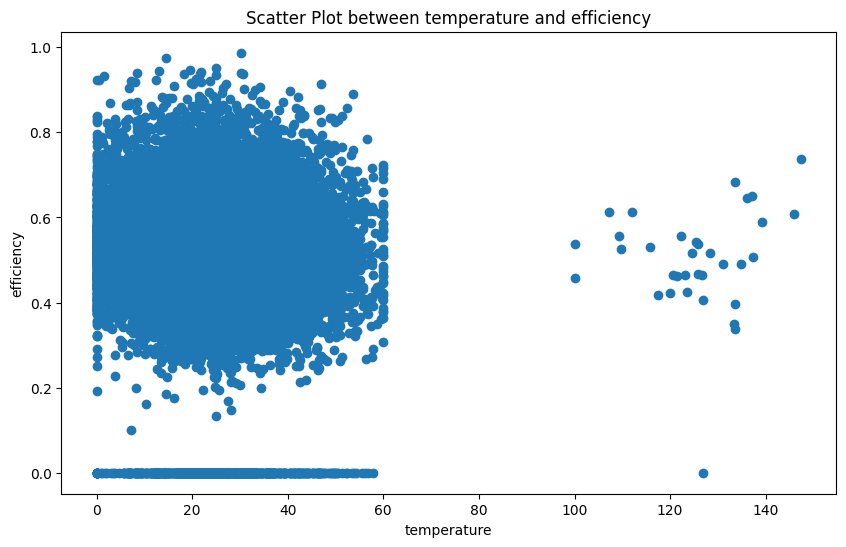

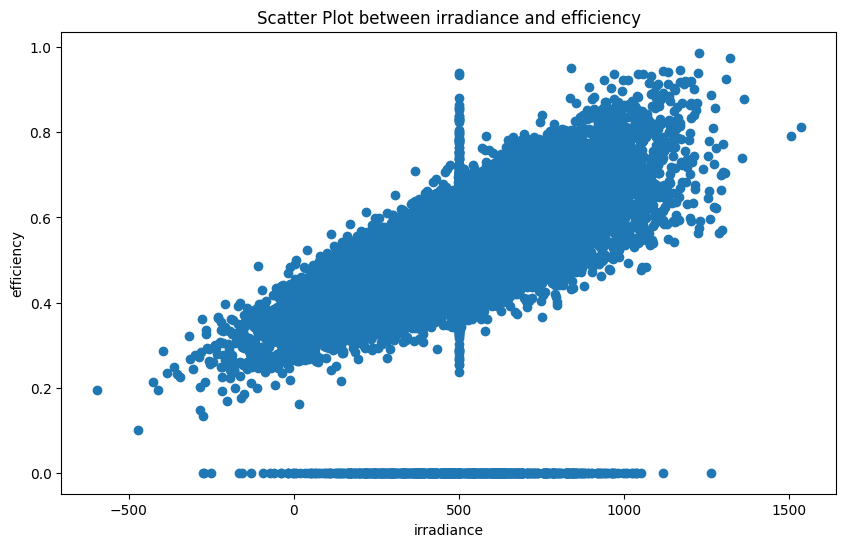

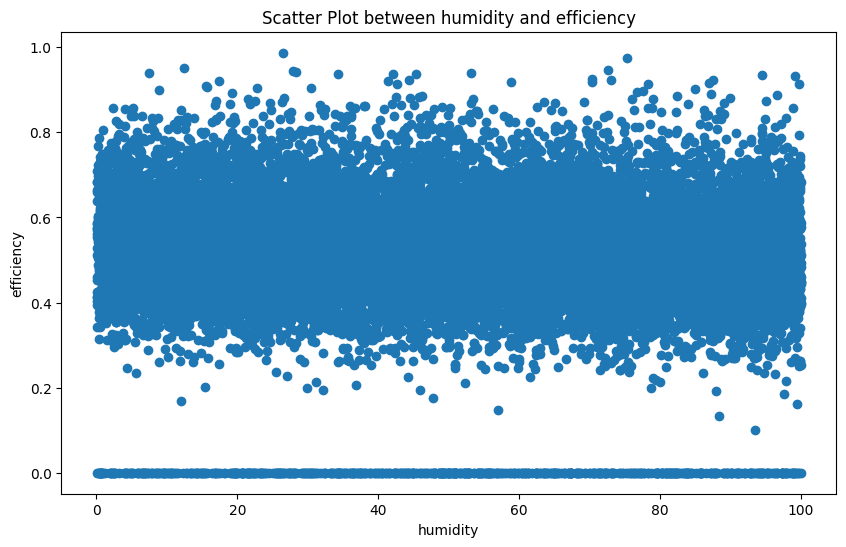

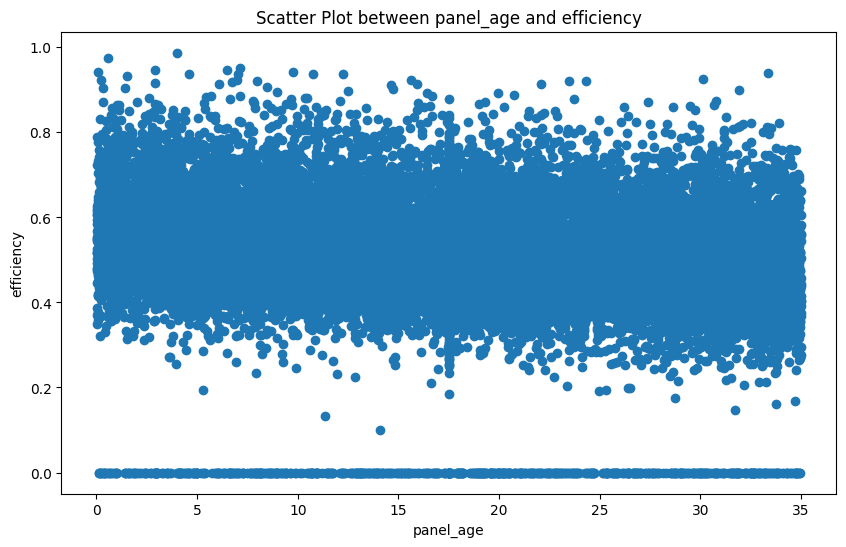

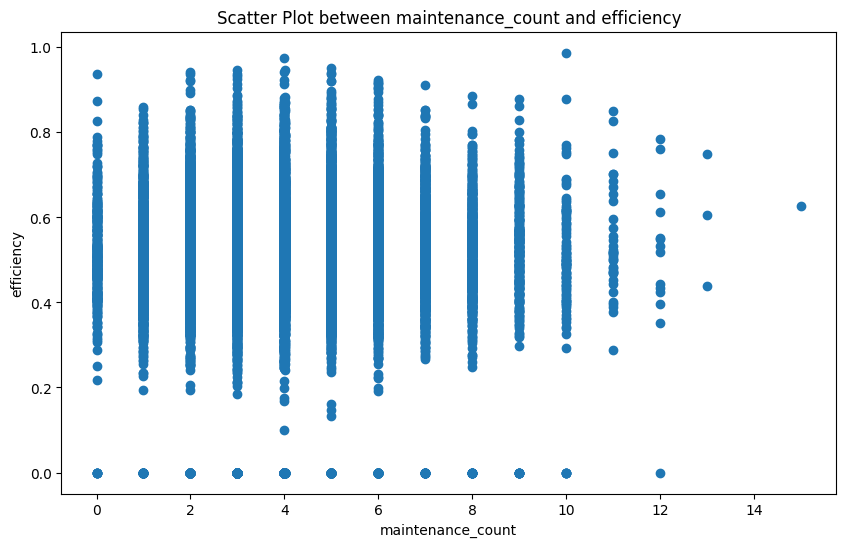

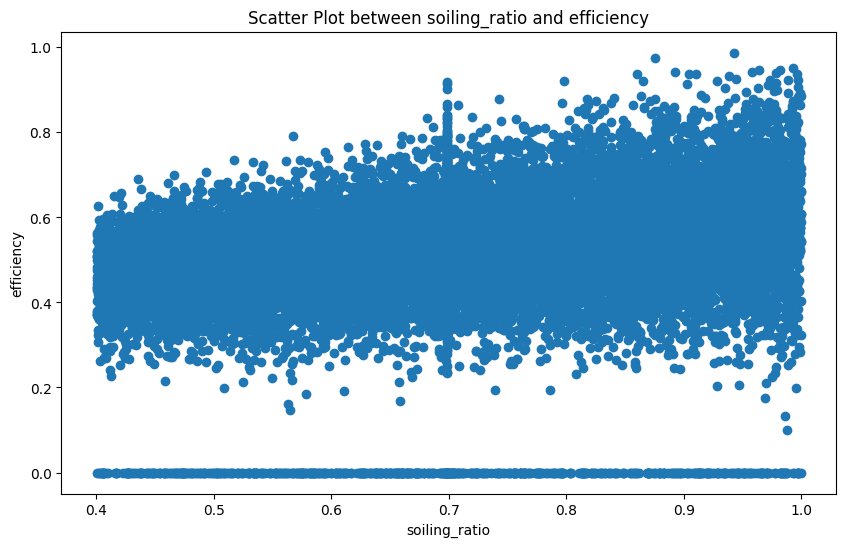

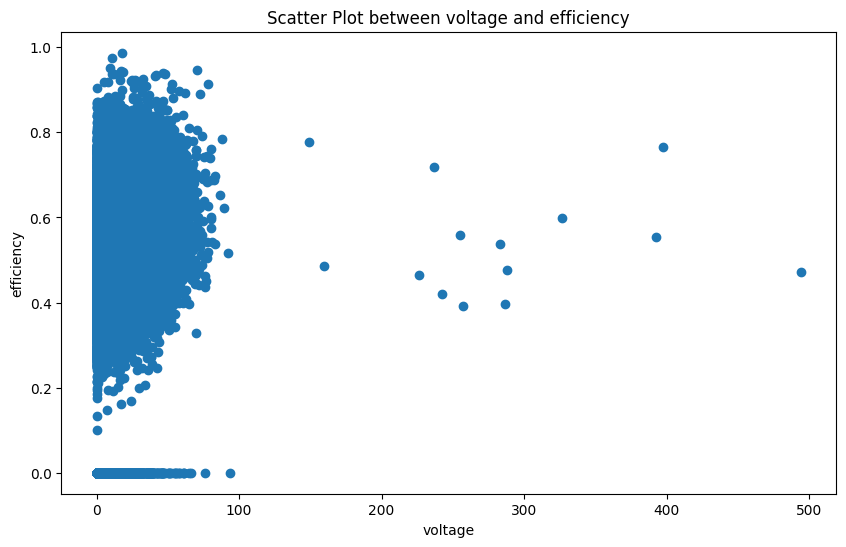

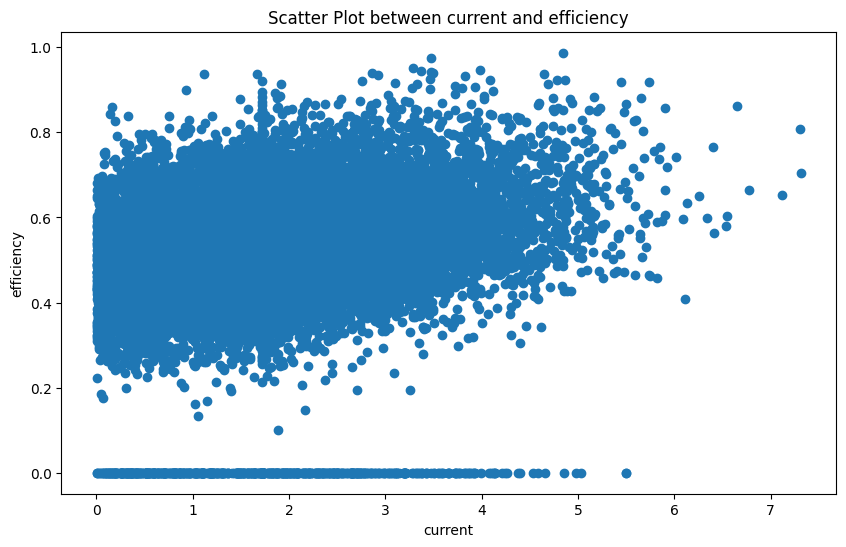

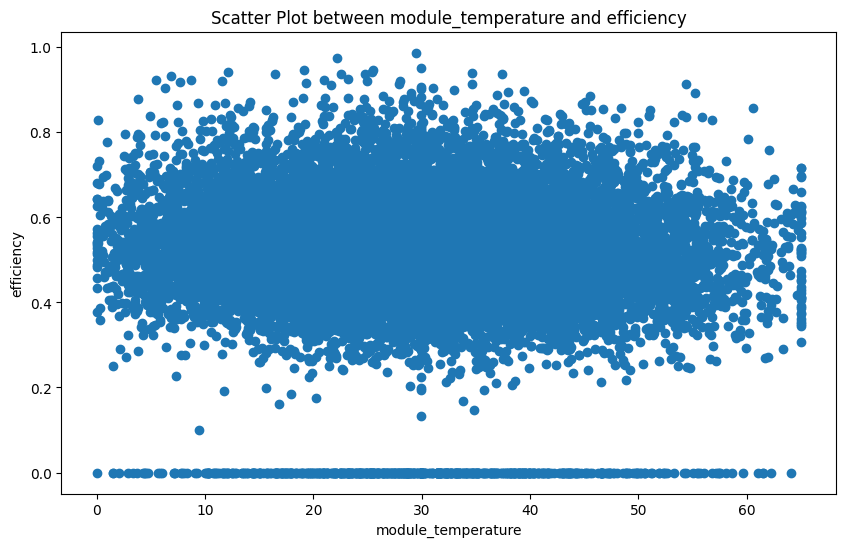

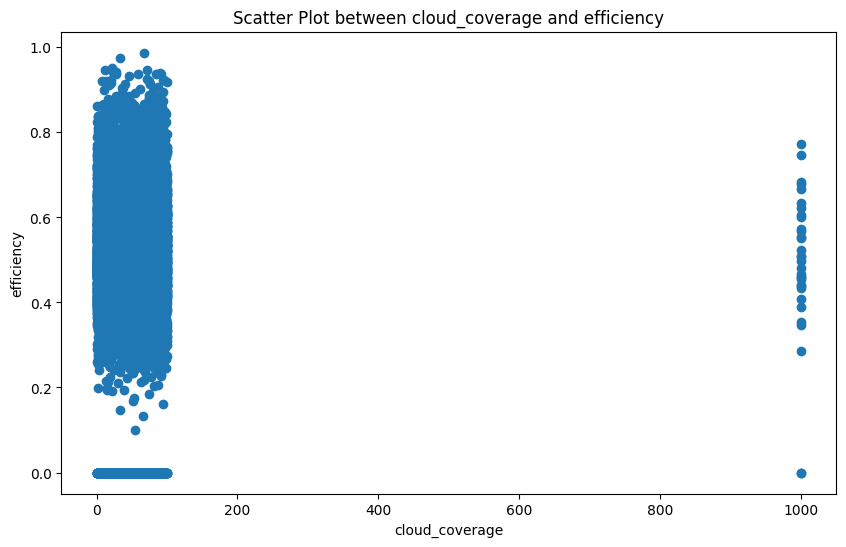

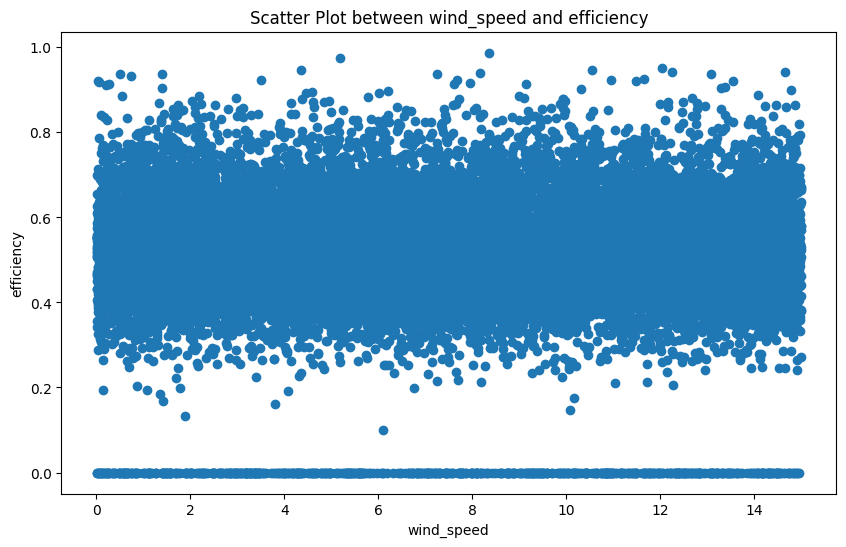

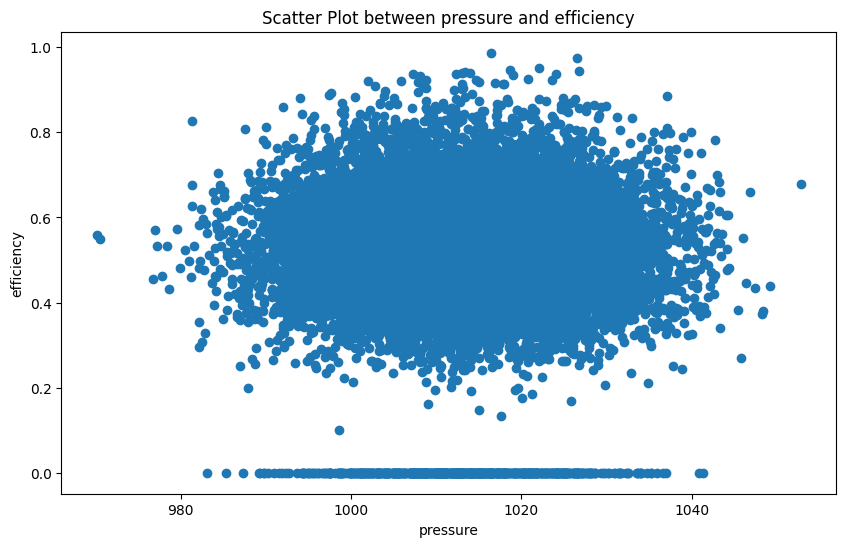

In [22]:
# Let's make a scatter chart per each numeric column and the efficiency, so we can see the correlation pattern
for col in numeric_columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(train[col], train['efficiency'])
    plt.xlabel(col)
    plt.ylabel("efficiency")
    plt.title(f"Scatter Plot between {col} and efficiency")
    plt.show()

### It can be seen that we have a high linear correlation between efficiency and irradiance, a lighter ones with current, soiling ratio and panel age.
### Also, it is obvious that we need to get rid of extreme, b ut let's check the box plot for each column

In [23]:
print(train[train['efficiency'] == 0].describe())

                 id  temperature   irradiance    humidity   panel_age  \
count    631.000000   631.000000   631.000000  631.000000  631.000000   
mean   10222.610143    25.220340   491.831403   50.483094   17.996260   
std     5835.119626    12.252481   247.316116   28.445008    9.807851   
min       81.000000     0.000000  -275.773988    0.028878    0.102278   
25%     4914.500000    17.556482   319.235121   26.365824    9.417978   
50%    10297.000000    24.697267   493.590168   50.464804   18.150840   
75%    15260.500000    32.144523   653.158741   74.923478   26.364245   
max    19938.000000   126.864184  1264.882807   99.967204   34.959899   

       maintenance_count  soiling_ratio     voltage     current  \
count         631.000000     631.000000  631.000000  631.000000   
mean            3.954845       0.694378   15.159003    1.712155   
std             1.904764       0.163843   15.146729    1.098842   
min             0.000000       0.400149    0.000000    0.005009   
25%    

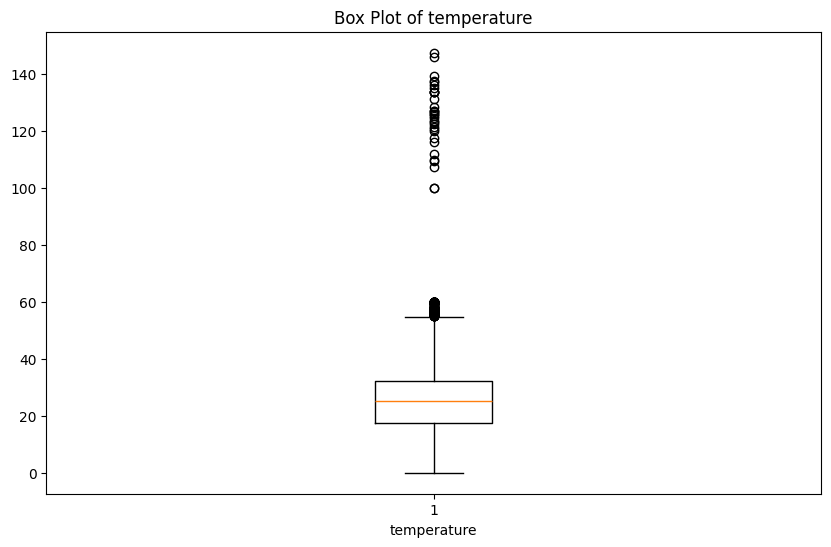

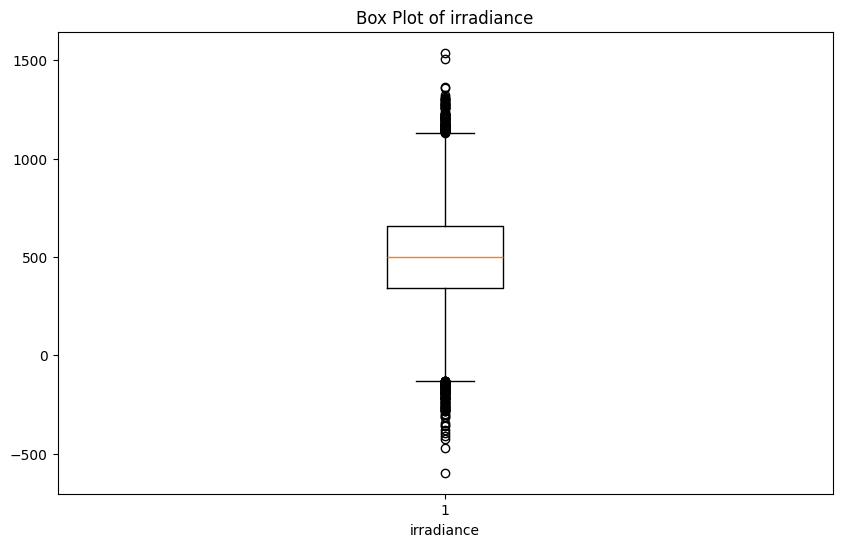

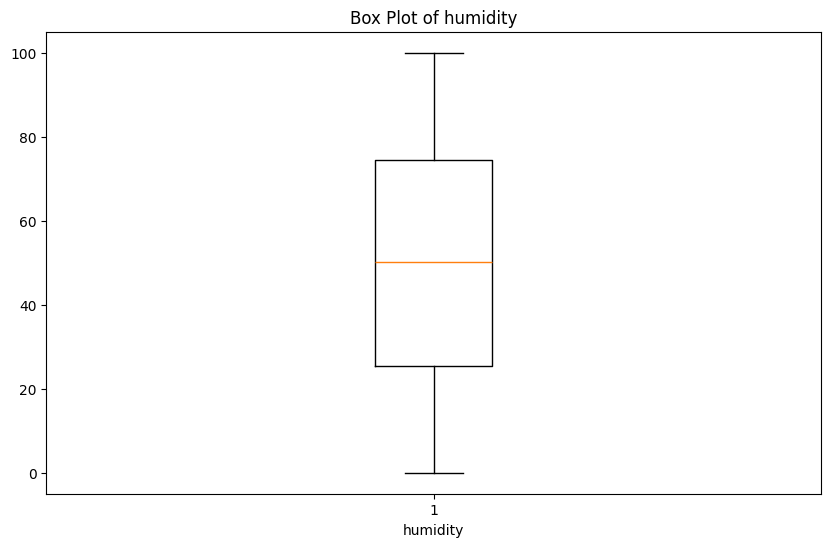

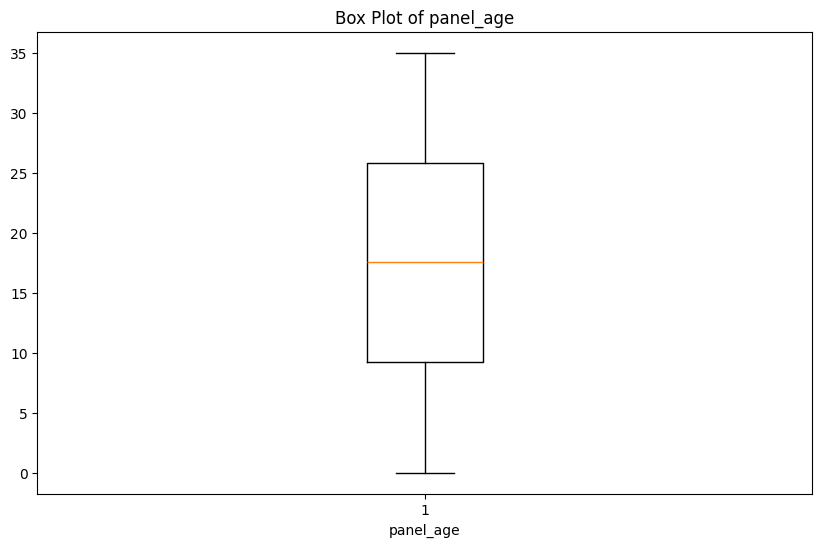

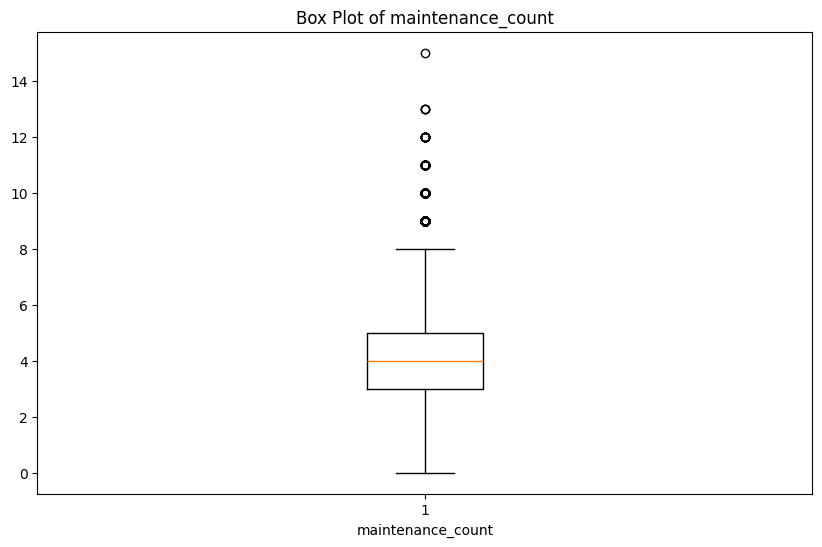

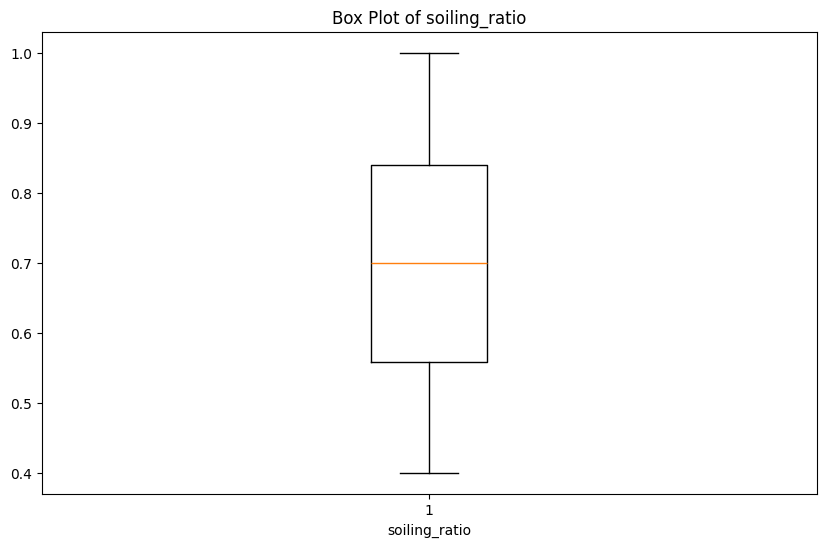

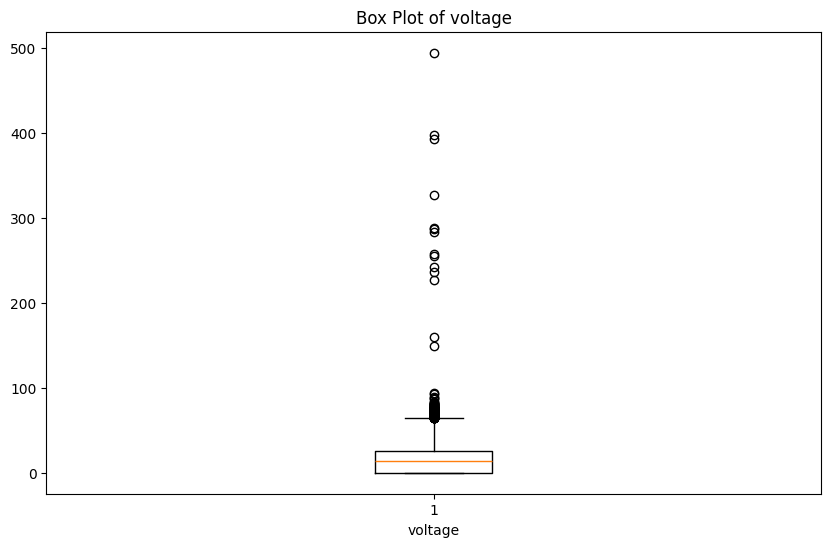

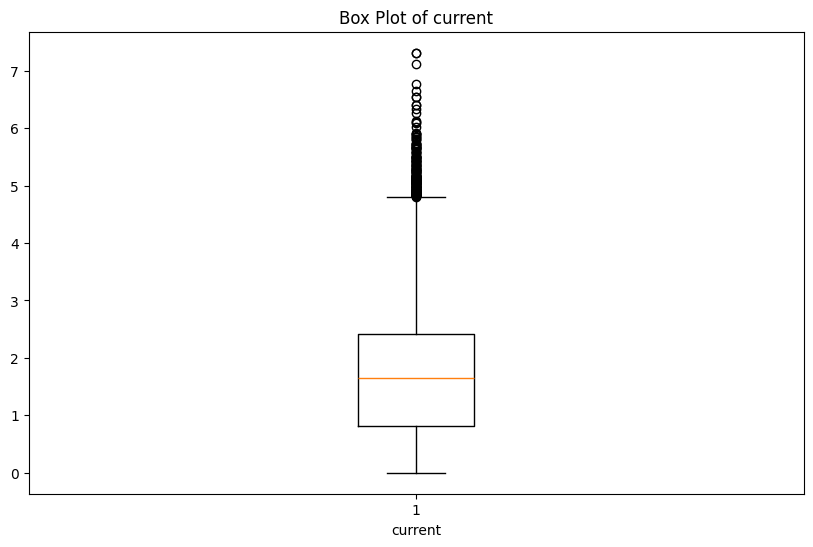

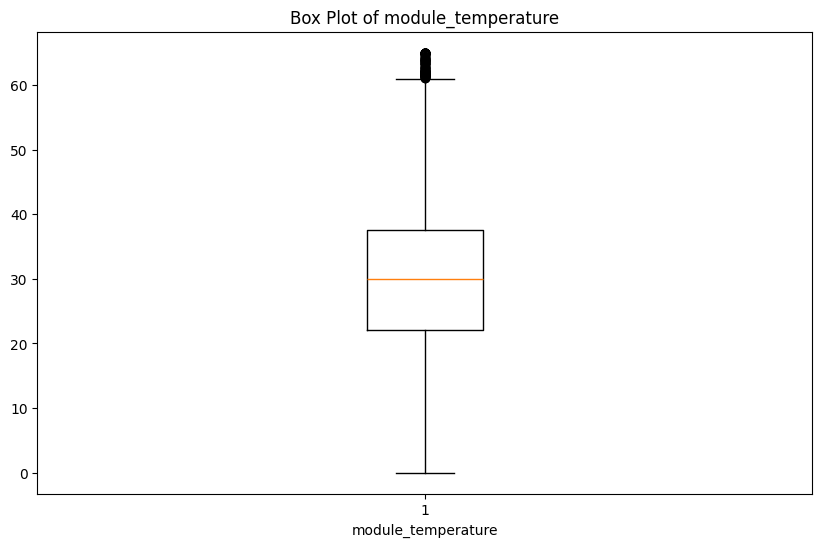

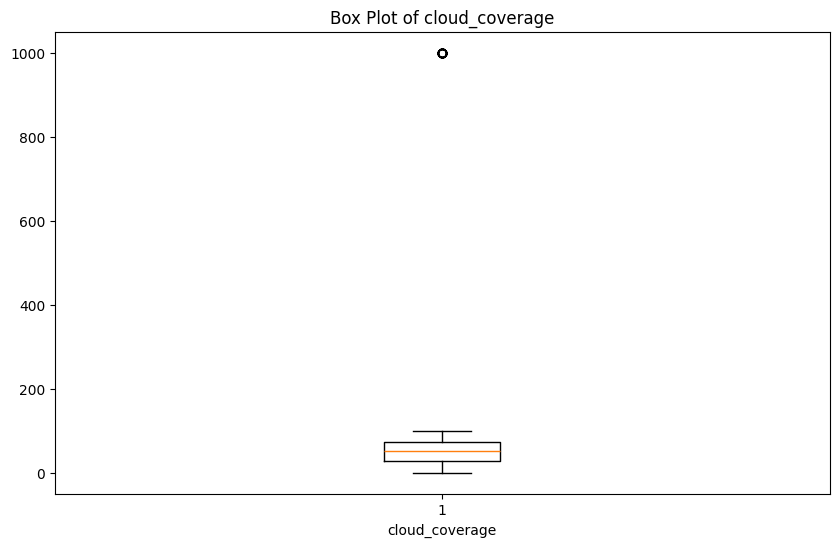

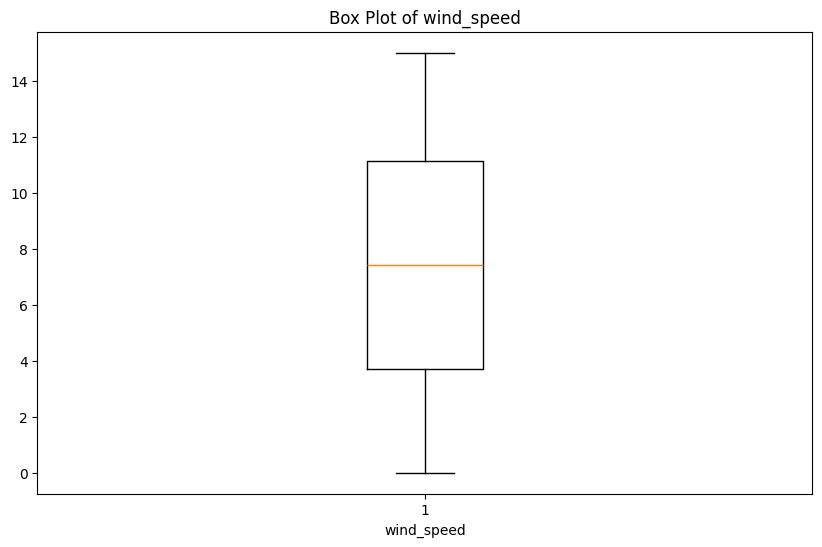

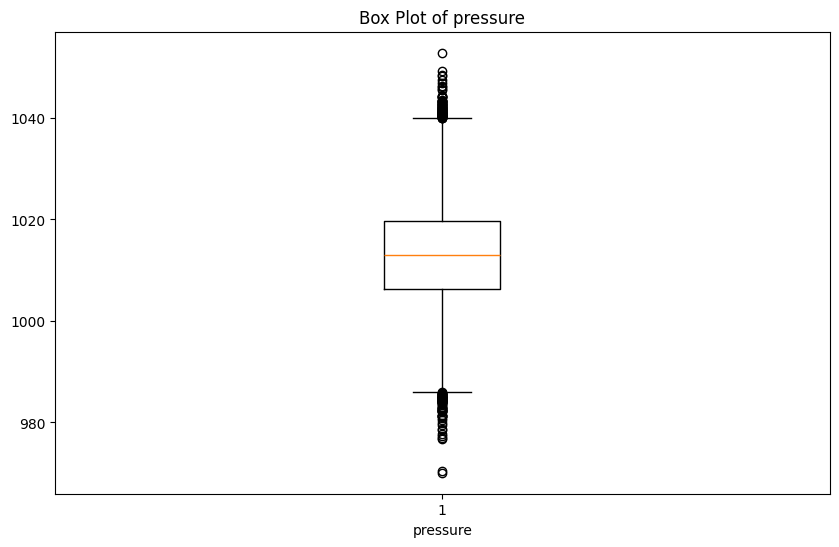

In [25]:
# Let's make a box plot for each numeric column to check for outliers
for col in numeric_columns:
    plt.figure(figsize=(10, 6))
    plt.boxplot(train[col])
    plt.xlabel(col)
    plt.title(f"Box Plot of {col}")
    plt.show()

### Most columns have outliers, so we need to correct it.

In [26]:
# Deal with outliers using the 20/80 quartile range for each numeric column
for col in numeric_columns:
    Q1 = train[col].quantile(0.20)
    Q3 = train[col].quantile(0.80)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    train = train[(train[col] >= lower_bound) & (train[col] <= upper_bound)]

print("Shape of the dataframe after removing outliers:", train.shape)

Shape of the dataframe after removing outliers: (19813, 17)


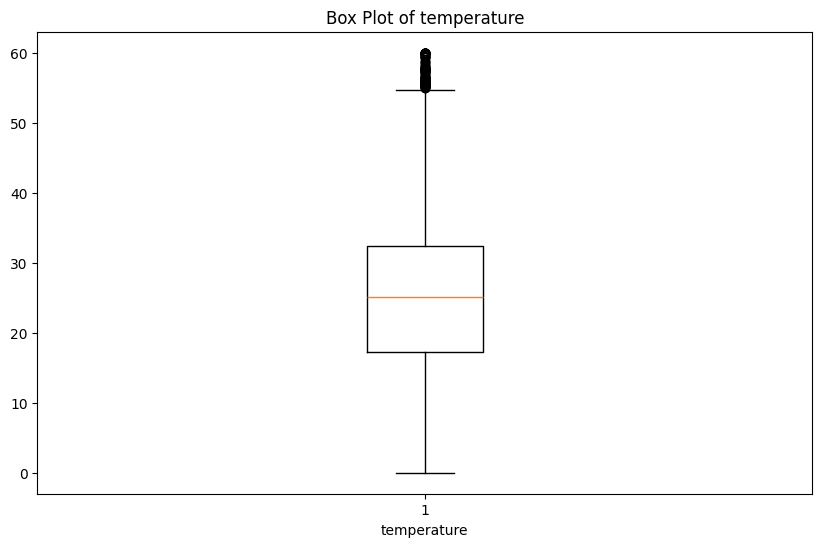

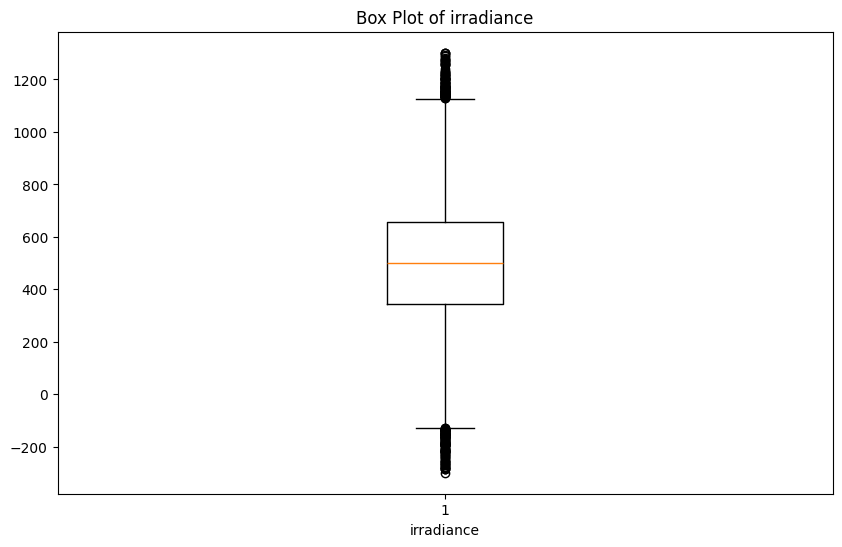

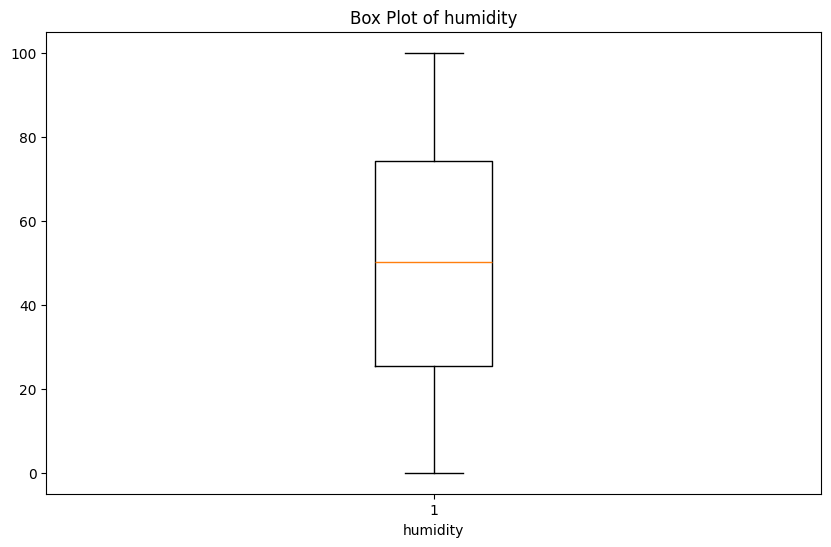

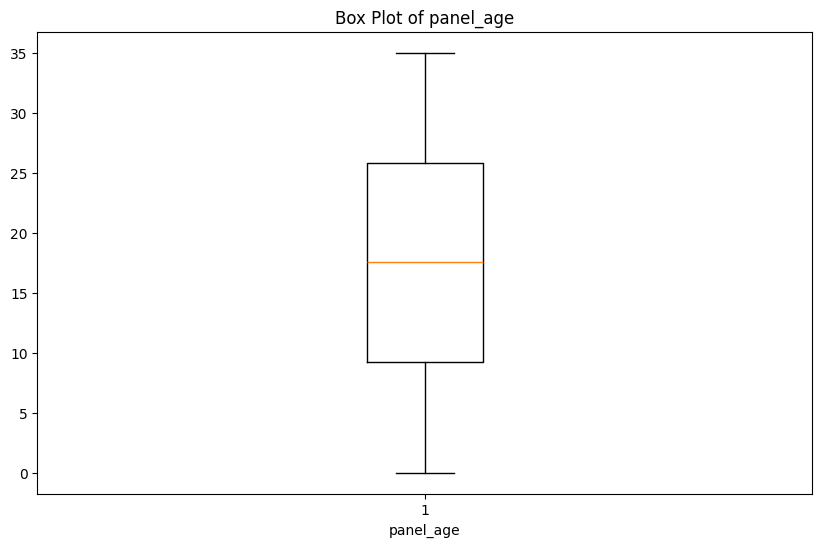

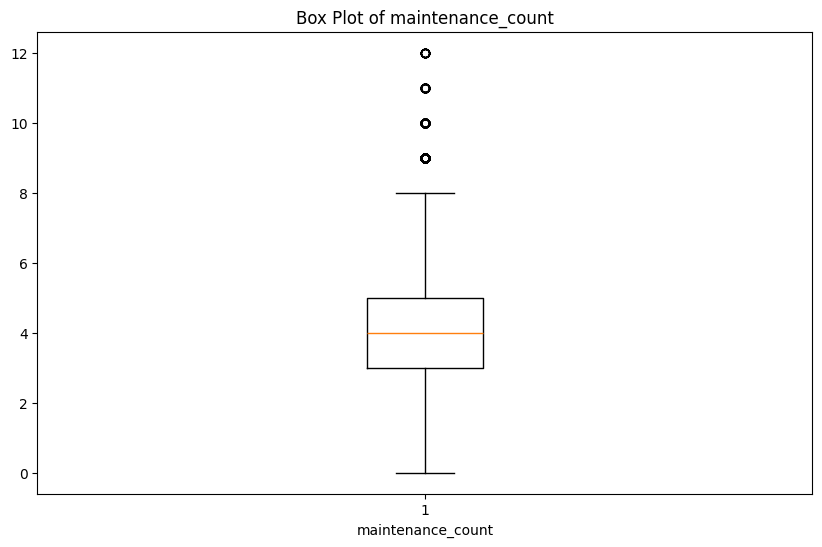

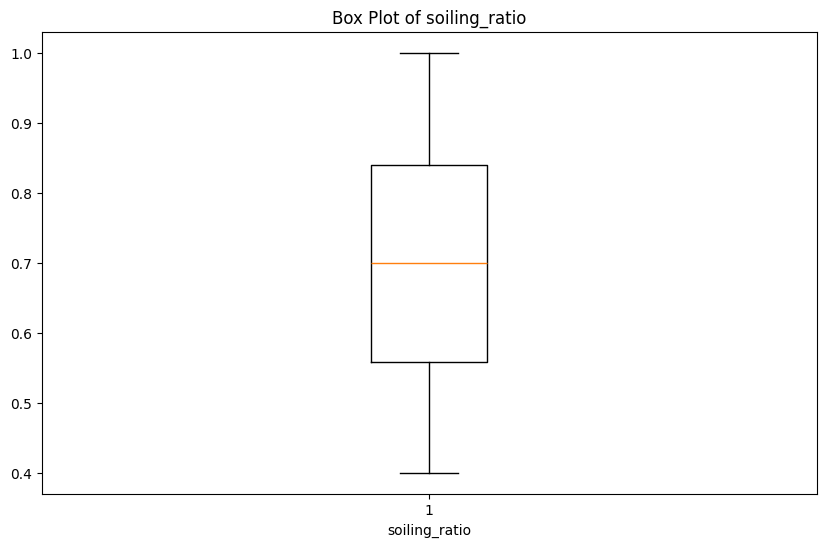

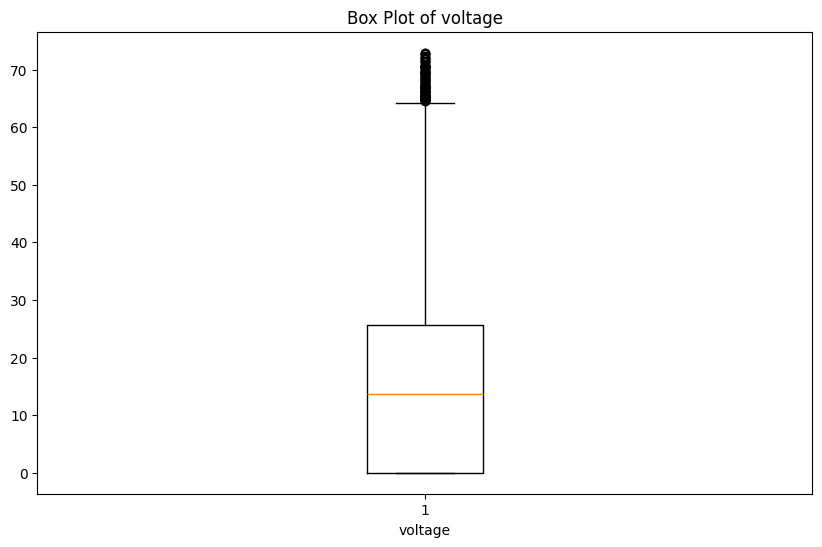

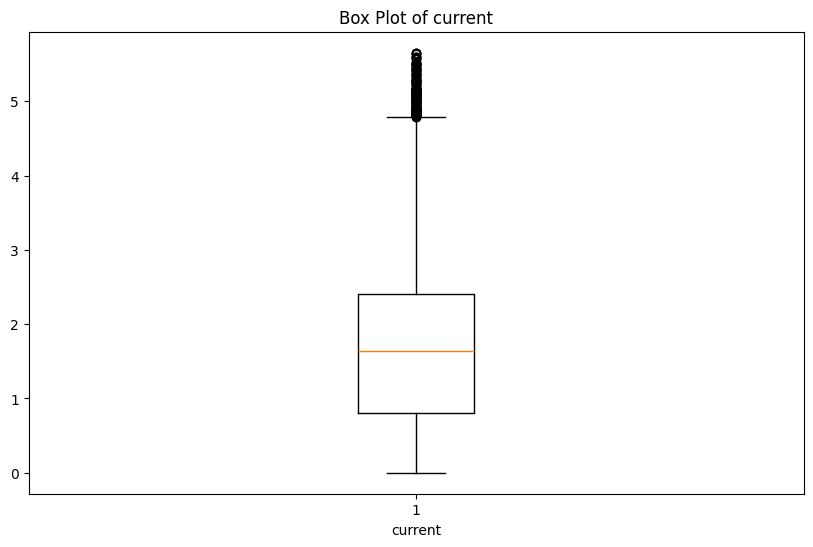

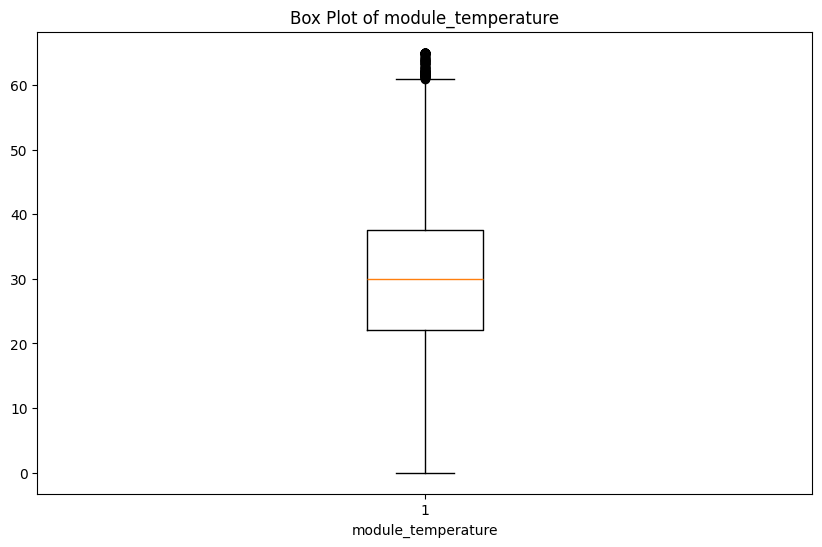

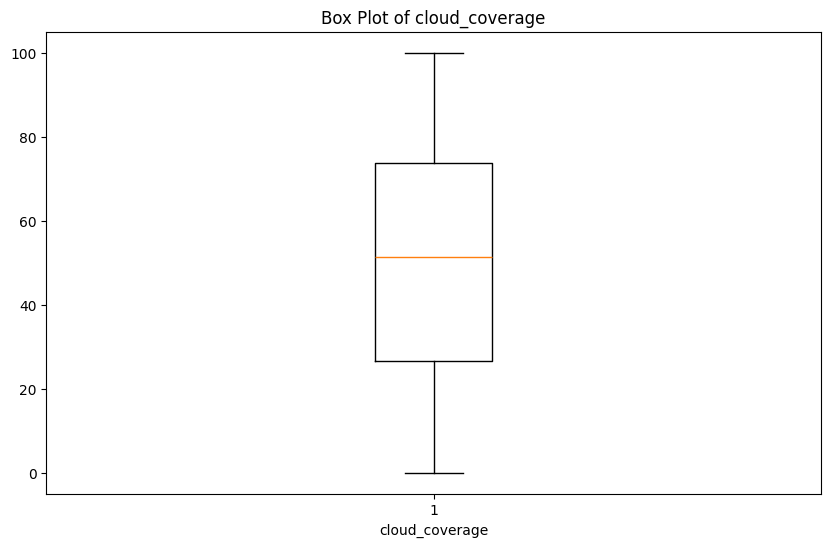

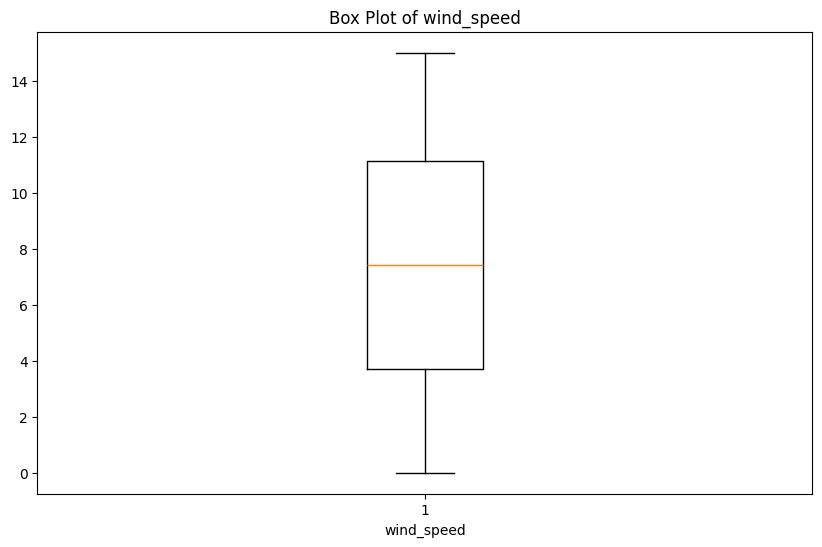

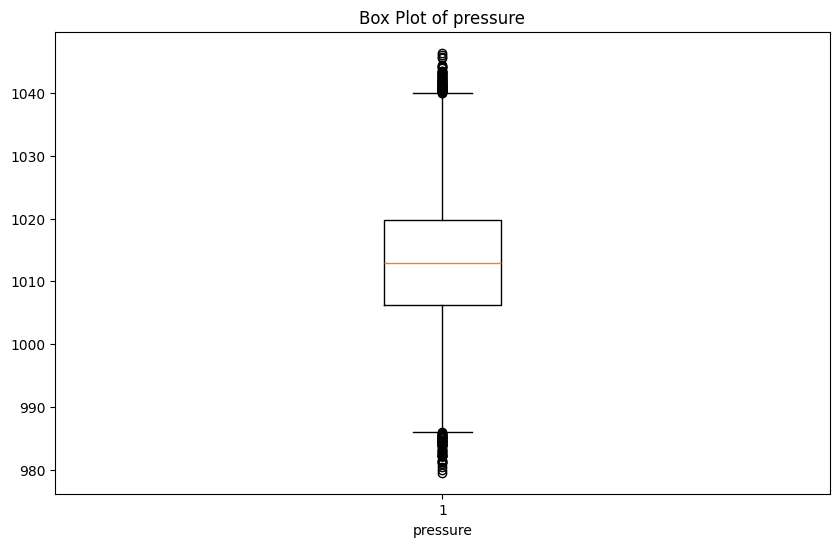

In [27]:
# Let's check the outliers with boxplots now:
for col in numeric_columns:
    plt.figure(figsize=(10, 6))
    plt.boxplot(train[col])
    plt.xlabel(col)
    plt.title(f"Box Plot of {col}")
    plt.show()

### Looks much better

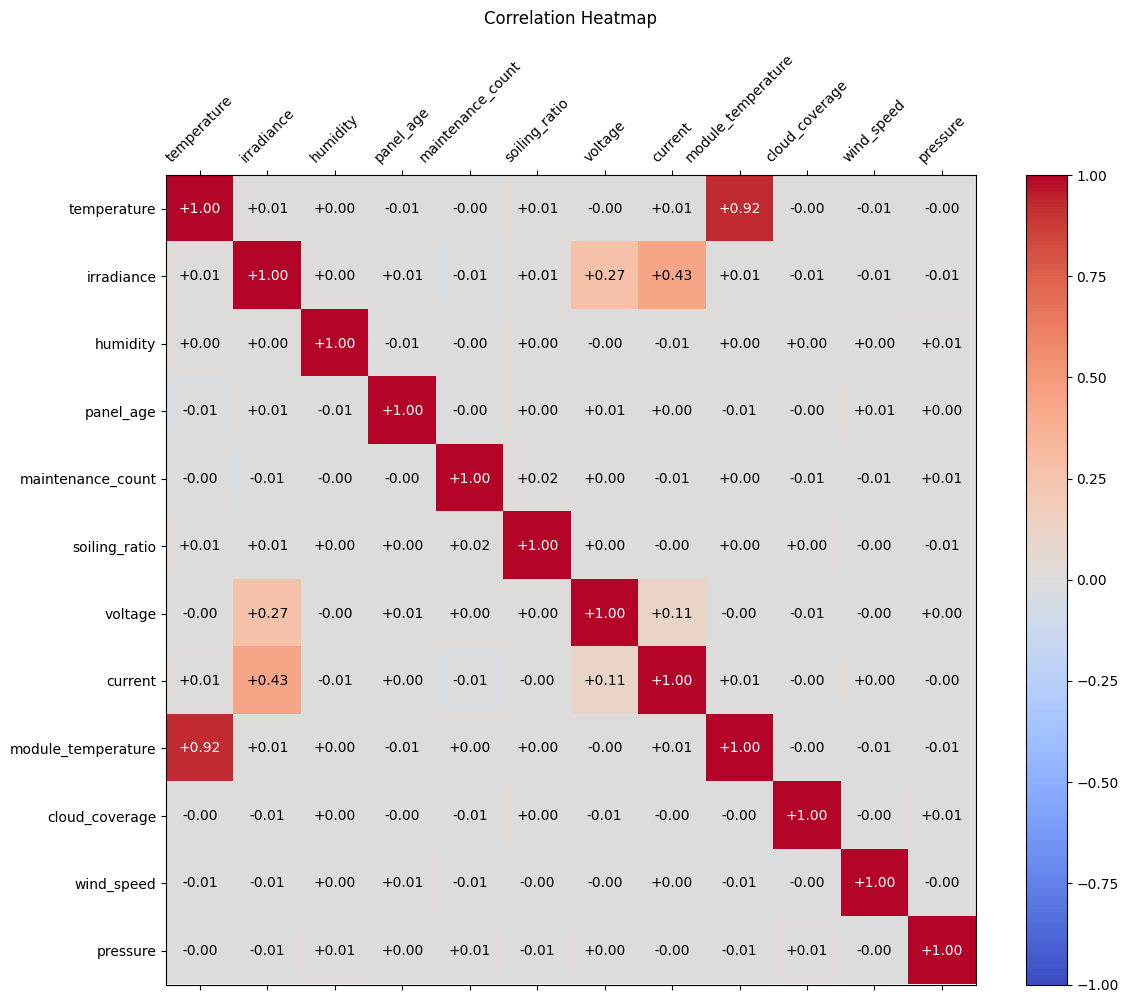

In [31]:
# Let's make a correlation heatmap
# Compute the correlation matrix for numeric columns
corr = train[numeric_columns].corr()

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
fig.colorbar(cax)

# Set ticks
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45)
ax.set_yticklabels(corr.columns)

# Add correlation values (with signs)
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        val = corr.iloc[i, j]
        ax.text(j, i, f"{val:+.2f}", va='center', ha='center', color='black' if abs(val) < 0.7 else 'white')

plt.title("Correlation Heatmap", pad=20)
plt.tight_layout()
plt.show()

### I will create 4 new columns, and probably get rid of other columns.

In [33]:
train['effective_irradiance'] = train['irradiance'] - 1 - train['soiling_ratio']
train['power_ratio'] = train['current'] * train['voltage']
train['overheat_margin'] = train['module_temperature'] - train['temperature']
train['maintenance_rate'] = train['maintenance_count'] / train['panel_age']

In [36]:
num_columns = train.select_dtypes(include=['float64', 'int64']).columns.tolist()

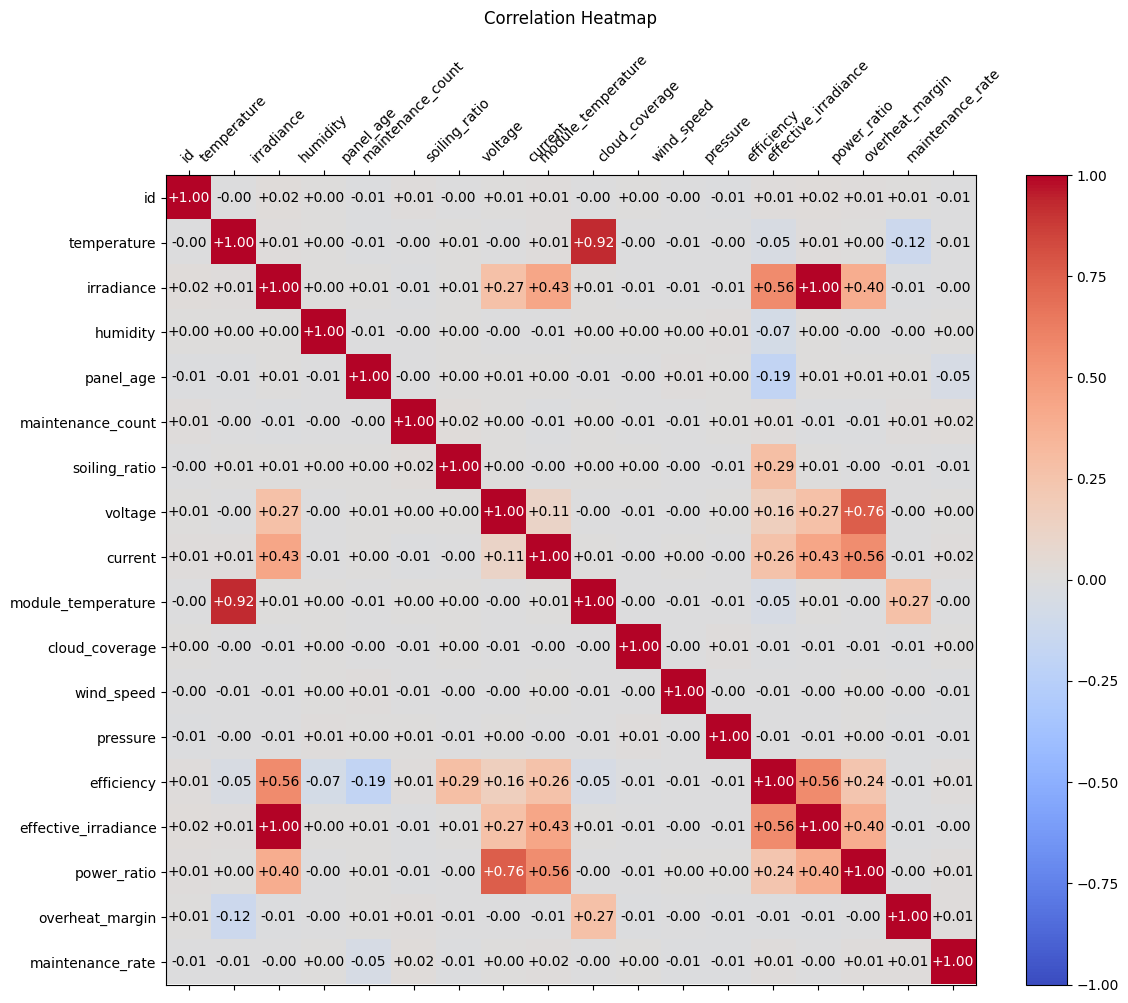

In [37]:
# Let's make a correlation heatmap
# Compute the correlation matrix for numeric columns
corr = train[num_columns].corr()

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)

# Add colorbar
fig.colorbar(cax)

# Set ticks
ax.set_xticks(np.arange(len(corr.columns)))
ax.set_yticks(np.arange(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45)
ax.set_yticklabels(corr.columns)

# Add correlation values (with signs)
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        val = corr.iloc[i, j]
        ax.text(j, i, f"{val:+.2f}", va='center', ha='center', color='black' if abs(val) < 0.7 else 'white')

plt.title("Correlation Heatmap", pad=20)
plt.tight_layout()
plt.show()

In [39]:
# Drop unnecessary columns
train = train.drop(columns=['module_temperature', 'voltage', 'current', 'effective_irradiance'])
print(train.columns)

Index(['id', 'temperature', 'irradiance', 'humidity', 'panel_age',
       'maintenance_count', 'soiling_ratio', 'cloud_coverage', 'wind_speed',
       'pressure', 'string_id', 'error_code', 'installation_type',
       'efficiency', 'power_ratio', 'overheat_margin', 'maintenance_rate'],
      dtype='object')


In [42]:
train = pd.get_dummies(train, columns=object_columns, dummy_na=True)

In [44]:
train = train.drop(columns=['id'])

# 4. Data training

In [46]:
X = train.drop(columns=["efficiency"])
y = train["efficiency"]

In [48]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [52]:
# RandomForest training
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_val)


rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))
score_rf = 100 * (1 - rmse_rf)

print("The RandomForest score is ", score_rf)

The RandomForest score is  89.24399217330003


In [53]:
# XGBoost training
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_val)

rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_rf))
score_xgb = 100 * (1 - rmse_xgb)

print("The XGBoost score is ", score_xgb)

The XGBoost score is  89.24399217330003


In [54]:
# Identify categorical feature indices
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype.name == 'category']

cat = CatBoostRegressor(verbose=0, random_state=42)
cat.fit(X_train, y_train, cat_features=cat_features)

y_pred_cat = cat.predict(X_val)

rmse_cat = np.sqrt(mean_squared_error(y_val, y_pred_cat))
score_cat = 100 * (1 - rmse_cat)

print("The CatBoost score is ", score_cat)

The CatBoost score is  89.42291153866755


In [68]:
# LightGBM Regressor
import lightgbm as lgb
from lightgbm.callback import early_stopping

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'verbose': -1,
    'random_state': 42
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[val_data], # Pass only the validation set for early stopping
    callbacks=[early_stopping(stopping_rounds=50, verbose=100)] # Use early_stopping callback
)

# Predict & evaluate
preds = model.predict(X_val, num_iteration=model.best_iteration)

rmse_lgb = np.sqrt(mean_squared_error(y_val, preds))
score_lgb = 100 * (1 - rmse_lgb)

print("The LightGBM score is ", score_lgb)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[87]	valid_0's rmse: 0.105003
The LightGBM score is  89.49966940153561


In [70]:
# TabNet regressor
# TabNet expects numpy arrays
X_train_np = X_train.values
y_train_np = y_train.values.reshape(-1, 1)
X_val_np = X_val.values
y_val_np = y_val.values.reshape(-1, 1)

# Convert boolean columns to integers (0 and 1)
for col in X_train.columns:
    if X_train[col].dtype == 'bool':
        X_train[col] = X_train[col].astype(int)
    if X_val[col].dtype == 'bool':
        X_val[col] = X_val[col].astype(int)

# Convert DataFrames to numpy arrays after type conversion
X_train_np = X_train.values
y_train_np = y_train.values.reshape(-1, 1)
X_val_np = X_val.values
y_val_np = y_val.values.reshape(-1, 1)


tabnet = TabNetRegressor(seed=42)

tabnet.fit(
    X_train_np, y_train_np,
    eval_set=[(X_val_np, y_val_np)],
    eval_name=['val'],
    eval_metric=['rmse'],
    max_epochs=100,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# Predict & evaluate
preds = tabnet.predict(X_val_np).reshape(-1)
rmse_tabnet = np.sqrt(mean_squared_error(y_val, preds))
score_tabnet = 100 * (1 - rmse_tabnet)

print("The TabNet score is ", score_tabnet)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.45451 | val_rmse: 11.54628|  0:00:02s
epoch 1  | loss: 0.03186 | val_rmse: 0.25452 |  0:00:04s
epoch 2  | loss: 0.02363 | val_rmse: 0.20251 |  0:00:06s
epoch 3  | loss: 0.0214  | val_rmse: 0.18825 |  0:00:07s
epoch 4  | loss: 0.0203  | val_rmse: 0.18026 |  0:00:08s
epoch 5  | loss: 0.01941 | val_rmse: 0.17313 |  0:00:10s
epoch 6  | loss: 0.01849 | val_rmse: 0.15851 |  0:00:11s
epoch 7  | loss: 0.01802 | val_rmse: 0.15719 |  0:00:13s
epoch 8  | loss: 0.01752 | val_rmse: 0.15151 |  0:00:15s
epoch 9  | loss: 0.01692 | val_rmse: 0.15488 |  0:00:16s
epoch 10 | loss: 0.0166  | val_rmse: 0.15    |  0:00:17s
epoch 11 | loss: 0.01642 | val_rmse: 0.1475  |  0:00:18s
epoch 12 | loss: 0.01597 | val_rmse: 0.14665 |  0:00:20s
epoch 13 | loss: 0.01556 | val_rmse: 0.14299 |  0:00:22s
epoch 14 | loss: 0.01537 | val_rmse: 0.14339 |  0:00:25s
epoch 15 | loss: 0.01492 | val_rmse: 0.13652 |  0:00:27s
epoch 16 | loss: 0.01463 | val_rmse: 0.13337 |  0:00:29s
epoch 17 | loss: 0.01448 | val_

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


The TabNet score is  89.40290286142213


### For the begining it's quite a good result, let's try to hypertune it

In [60]:
def custom_score(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return 100 * (1 - rmse)

def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 1500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),  # Keep <=1.0
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
    }

    model = XGBRegressor(**params, random_state=42, n_jobs=-1)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    scores = []
    for train_idx, val_idx in kf.split(X_train):
        X_t, X_v = X.iloc[train_idx], X.iloc[val_idx]
        y_t, y_v = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_t, y_t)
        preds = model.predict(X_v)
        score = custom_score(y_v, preds)
        scores.append(score)

    # Since Optuna minimizes the objective, return negative of your score
    return -np.mean(scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective_xgb, n_trials=50)

print("Best parameters:", study.best_params)
print("Best custom score:", -study.best_value)  # Return to original positive form

[I 2025-06-03 07:26:19,863] A new study created in memory with name: no-name-6fd9a76a-b571-4013-a89c-59414e733722
[I 2025-06-03 07:26:26,029] Trial 0 finished with value: -89.6208894552991 and parameters: {'n_estimators': 633, 'max_depth': 7, 'learning_rate': 0.030277052662380406, 'subsample': 0.7111693370135255, 'colsample_bytree': 0.5860192569545963, 'reg_alpha': 7.569007883989977, 'reg_lambda': 0.33229702185355925}. Best is trial 0 with value: -89.6208894552991.
[I 2025-06-03 07:26:36,967] Trial 1 finished with value: -89.62732220703141 and parameters: {'n_estimators': 987, 'max_depth': 5, 'learning_rate': 0.047304379298938874, 'subsample': 0.9033977980718195, 'colsample_bytree': 0.7650591522911356, 'reg_alpha': 5.00156495701777, 'reg_lambda': 4.654508031607731}. Best is trial 1 with value: -89.62732220703141.
[I 2025-06-03 07:26:54,637] Trial 2 finished with value: -89.4891355136768 and parameters: {'n_estimators': 892, 'max_depth': 9, 'learning_rate': 0.005906349803048947, 'subsam

Best parameters: {'n_estimators': 1070, 'max_depth': 3, 'learning_rate': 0.00861994426208262, 'subsample': 0.8369632360388488, 'colsample_bytree': 0.7715254412117467, 'reg_alpha': 0.3839765399681454, 'reg_lambda': 2.5876159429238084}
Best custom score: 89.73565394084784


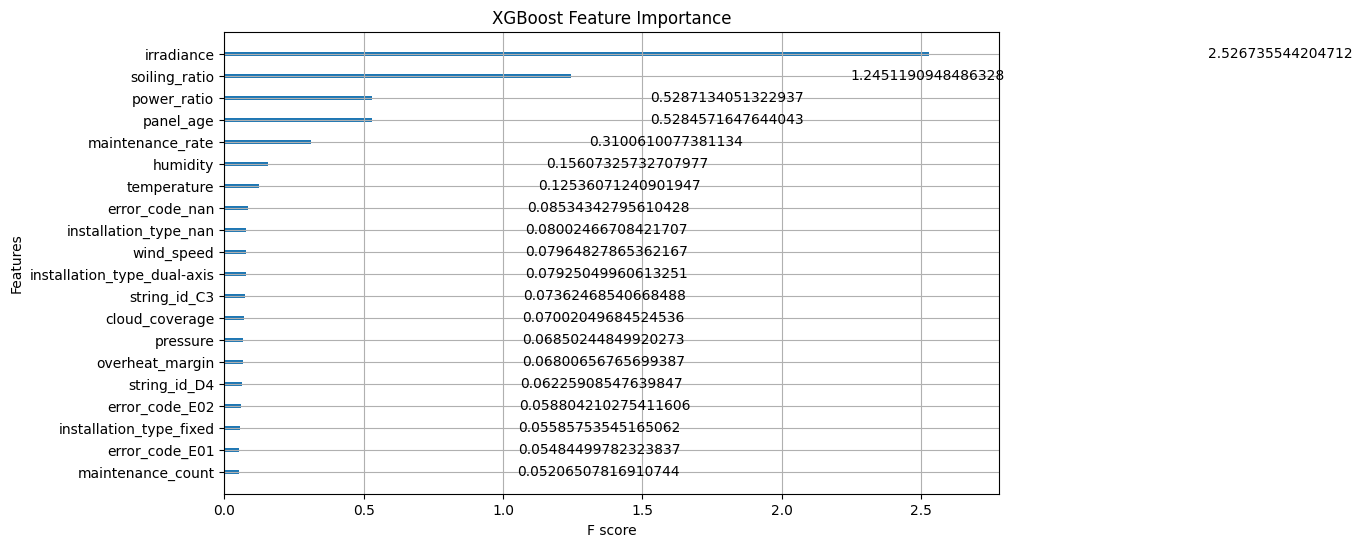

In [64]:
best_params_xgb = study.best_params

best_model_xgb = XGBRegressor(
    **best_params_xgb,
    random_state=42,
    n_jobs=-1
)

# Train on full training data
best_model_xgb.fit(X_train, y_train)

# Now get feature importance
import xgboost as xgb
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(best_model_xgb, max_num_features=20, importance_type='gain', ax=ax)
plt.title("XGBoost Feature Importance")
plt.show()

In [75]:
# LightGBM hypertuning
def objective_lgb(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 20, 40),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 30, 60),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.5, 20.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.5, 20.0),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 1.0),
        "max_bin": trial.suggest_int("max_bin", 128, 512),
        "extra_trees": trial.suggest_categorical("extra_trees", [True, False]),
        "boosting": trial.suggest_categorical("boosting", ["gbdt", "dart", "goss"]),
        'random_state': 42,
        'n_jobs': -1
    }

    # Add bagging parameters only if boosting is not 'goss'
    if params['boosting'] != 'goss':
        params["feature_fraction"] = trial.suggest_float("feature_fraction", 0.9, 1.0)
        params["bagging_fraction"] = trial.suggest_float("bagging_fraction", 0.9, 1.0)
        params["bagging_freq"] = trial.suggest_int("bagging_freq", 5, 10)


    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(X):
        X_t, X_v = X.iloc[train_idx], X.iloc[val_idx]
        y_t, y_v = y.iloc[train_idx], y.iloc[val_idx]

        train_data = lgb.Dataset(X_t, label=y_t)
        val_data = lgb.Dataset(X_v, label=y_v, reference=train_data)

        model = lgb.train(
            params,
            train_data,
            valid_sets=[val_data],
            callbacks=[early_stopping(stopping_rounds=100, verbose=100)]
        )

        preds = model.predict(X_v, num_iteration=model.best_iteration)
        score = custom_score(y_v, preds)
        scores.append(score)

    return -np.mean(scores)  # minimize negative score


study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=50)

print("Best LightGBM params:", study_lgb.best_params)
print("Best LightGBM custom score:", -study_lgb.best_value)

[I 2025-06-03 08:04:29,014] A new study created in memory with name: no-name-0ac7f014-ad06-4222-b4bf-fffe4f1cc410


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's rmse: 0.106363
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:04:29,490] Trial 0 finished with value: -89.39627681474268 and parameters: {'learning_rate': 0.10436375328946133, 'num_leaves': 28, 'max_depth': 4, 'min_data_in_leaf': 36, 'lambda_l1': 2.9113933061723434, 'lambda_l2': 12.203343364752884, 'min_gain_to_split': 0.8718271561537425, 'max_bin': 449, 'extra_trees': True, 'boosting': 'gbdt', 'feature_fraction': 0.9168188653227891, 'bagging_fraction': 0.9052252717991632, 'bagging_freq': 5}. Best is trial 0 with value: -89.39627681474268.


Did not meet early stopping. Best iteration is:
[79]	valid_0's rmse: 0.103989
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[66]	valid_0's rmse: 0.107759
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's rmse: 0.10647
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:04:29,943] Trial 1 finished with value: -89.42019249095118 and parameters: {'learning_rate': 0.13560146309390292, 'num_leaves': 36, 'max_depth': 6, 'min_data_in_leaf': 54, 'lambda_l1': 12.742076953588704, 'lambda_l2': 8.275654023288897, 'min_gain_to_split': 0.3807940063954254, 'max_bin': 335, 'extra_trees': True, 'boosting': 'gbdt', 'feature_fraction': 0.9661164417476855, 'bagging_fraction': 0.996459702965705, 'bagging_freq': 7}. Best is trial 1 with value: -89.42019249095118.


Did not meet early stopping. Best iteration is:
[63]	valid_0's rmse: 0.103652
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[79]	valid_0's rmse: 0.107272
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[29]	valid_0's rmse: 0.108082
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:04:30,373] Trial 2 finished with value: -89.26144510486313 and parameters: {'learning_rate': 0.12223935264187646, 'num_leaves': 33, 'max_depth': 4, 'min_data_in_leaf': 44, 'lambda_l1': 18.742579273254204, 'lambda_l2': 0.5935799251951994, 'min_gain_to_split': 0.5628806648537676, 'max_bin': 367, 'extra_trees': False, 'boosting': 'gbdt', 'feature_fraction': 0.9312294491157651, 'bagging_fraction': 0.9906992069142206, 'bagging_freq': 8}. Best is trial 1 with value: -89.42019249095118.


Did not meet early stopping. Best iteration is:
[29]	valid_0's rmse: 0.105357
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's rmse: 0.108717


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
[I 2025-06-03 08:04:31,616] Trial 3 finished with value: -41.29414905912242 and parameters: {'learning_rate': 0.0944185026950222, 'num_leaves': 38, 'max_depth': 2, 'min_data_in_leaf': 42, 'lambda_l1': 15.461534355772992, 'lambda_l2': 11.467678720183065, 'min_gain_to_split': 0.8993607210184715, 'max_bin': 197, 'extra_trees': True, 'boosting': 'dart', 'feature_fraction': 0.9183480420942136, 'bagging_fraction': 0.9618336572464234, 'baggin

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's rmse: 0.105544
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:04:32,154] Trial 4 finished with value: -89.50450141769456 and parameters: {'learning_rate': 0.14430329869386152, 'num_leaves': 21, 'max_depth': 5, 'min_data_in_leaf': 42, 'lambda_l1': 19.164015055562935, 'lambda_l2': 0.7646696600294804, 'min_gain_to_split': 0.09630882147484077, 'max_bin': 316, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 4 with value: -89.50450141769456.


Did not meet early stopping. Best iteration is:
[77]	valid_0's rmse: 0.102771
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's rmse: 0.10655
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[87]	valid_0's rmse: 0.108066
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[70]	valid_0's rmse: 0.105657


[I 2025-06-03 08:04:32,826] Trial 5 finished with value: -89.24131447188012 and parameters: {'learning_rate': 0.0990037395668158, 'num_leaves': 20, 'max_depth': 3, 'min_data_in_leaf': 56, 'lambda_l1': 18.968092368235396, 'lambda_l2': 18.08734932411993, 'min_gain_to_split': 0.7711379601834394, 'max_bin': 276, 'extra_trees': True, 'boosting': 'gbdt', 'feature_fraction': 0.9137036184423271, 'bagging_fraction': 0.9774889031854925, 'bagging_freq': 7}. Best is trial 4 with value: -89.50450141769456.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's rmse: 0.109038
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[37]	valid_0's rmse: 0.107306
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[36]	valid_0's rmse: 0.104922


[I 2025-06-03 08:04:33,272] Trial 6 finished with value: -89.31625030492965 and parameters: {'learning_rate': 0.09061630557395217, 'num_leaves': 25, 'max_depth': 4, 'min_data_in_leaf': 30, 'lambda_l1': 8.92351734293253, 'lambda_l2': 12.045641807629448, 'min_gain_to_split': 0.7790630507092116, 'max_bin': 363, 'extra_trees': False, 'boosting': 'gbdt', 'feature_fraction': 0.9837060546512605, 'bagging_fraction': 0.9494298506898835, 'bagging_freq': 5}. Best is trial 4 with value: -89.50450141769456.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[38]	valid_0's rmse: 0.108285
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[51]	valid_0's rmse: 0.106455
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[48]	valid_0's rmse: 0.103826


[I 2025-06-03 08:04:33,753] Trial 7 finished with value: -89.41422373174284 and parameters: {'learning_rate': 0.12359554960070276, 'num_leaves': 35, 'max_depth': 2, 'min_data_in_leaf': 31, 'lambda_l1': 19.121202746676943, 'lambda_l2': 4.999413678052137, 'min_gain_to_split': 0.1368787181727552, 'max_bin': 325, 'extra_trees': False, 'boosting': 'gbdt', 'feature_fraction': 0.9530553029100745, 'bagging_fraction': 0.955331043447034, 'bagging_freq': 7}. Best is trial 4 with value: -89.50450141769456.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[51]	valid_0's rmse: 0.107292
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's rmse: 0.1042
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[78]	valid_0's rmse: 0.10101
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:04:36,552] Trial 8 finished with value: -89.66278613010735 and parameters: {'learning_rate': 0.14225437146899672, 'num_leaves': 35, 'max_depth': 2, 'min_data_in_leaf': 38, 'lambda_l1': 2.605724345761338, 'lambda_l2': 8.048145795272578, 'min_gain_to_split': 0.03472939761250948, 'max_bin': 305, 'extra_trees': False, 'boosting': 'gbdt', 'feature_fraction': 0.9804761221105152, 'bagging_fraction': 0.9124169489450807, 'bagging_freq': 8}. Best is trial 8 with value: -89.66278613010735.


Did not meet early stopping. Best iteration is:
[81]	valid_0's rmse: 0.104907


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
[I 2025-06-03 08:04:38,685] Trial 9 finished with value: -56.21488732064827 and parameters: {'learning_rate': 0.10432681549021415, 'num_leaves': 37, 'max_depth': 3, 'min_data_in_leaf': 34, 'lambda_l1': 9.984584465885902, 'lambda_l2': 9.38991798529149, 'min_gain_to_split': 0.5773686081387456, 'max_bin': 448, 'extra_trees': True, 'boosting': 'dart', 'feature_fraction': 0.9431779748279212, 'bagging_fraction': 0.9182989601601845, 'bagging_

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's rmse: 0.104498
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:04:39,236] Trial 10 finished with value: -89.62378559888202 and parameters: {'learning_rate': 0.18143358531567727, 'num_leaves': 40, 'max_depth': 2, 'min_data_in_leaf': 47, 'lambda_l1': 0.6430035812135291, 'lambda_l2': 16.949358871614727, 'min_gain_to_split': 0.3365092358089357, 'max_bin': 138, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 8 with value: -89.66278613010735.


Did not meet early stopping. Best iteration is:
[78]	valid_0's rmse: 0.101423
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[54]	valid_0's rmse: 0.105363
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's rmse: 0.104574
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:04:39,797] Trial 11 finished with value: -89.61682813783834 and parameters: {'learning_rate': 0.1890879485829849, 'num_leaves': 40, 'max_depth': 2, 'min_data_in_leaf': 49, 'lambda_l1': 1.7471739482100141, 'lambda_l2': 18.469310210917982, 'min_gain_to_split': 0.3194878545176028, 'max_bin': 130, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 8 with value: -89.66278613010735.


Did not meet early stopping. Best iteration is:
[86]	valid_0's rmse: 0.101555
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[85]	valid_0's rmse: 0.105366
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[77]	valid_0's rmse: 0.104152
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[69]	valid_0's rmse: 0.101167
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:04:40,768] Trial 12 finished with value: -89.65778400034873 and parameters: {'learning_rate': 0.17032885755227886, 'num_leaves': 32, 'max_depth': 3, 'min_data_in_leaf': 49, 'lambda_l1': 5.2081068238003905, 'lambda_l2': 15.469055252518293, 'min_gain_to_split': 0.021338513700880024, 'max_bin': 234, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 8 with value: -89.66278613010735.


Did not meet early stopping. Best iteration is:
[73]	valid_0's rmse: 0.104913
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.104587
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.101752
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:04:41,583] Trial 13 finished with value: -89.60921680860584 and parameters: {'learning_rate': 0.05177368486740473, 'num_leaves': 31, 'max_depth': 3, 'min_data_in_leaf': 60, 'lambda_l1': 5.611465117591031, 'lambda_l2': 14.371294434332455, 'min_gain_to_split': 0.03271103585074767, 'max_bin': 238, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 8 with value: -89.66278613010735.


Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.105385
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 0.104519
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[74]	valid_0's rmse: 0.101537
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:04:42,464] Trial 14 finished with value: -89.62412562186357 and parameters: {'learning_rate': 0.1646220192355016, 'num_leaves': 29, 'max_depth': 3, 'min_data_in_leaf': 39, 'lambda_l1': 5.650504908920151, 'lambda_l2': 5.827164954877708, 'min_gain_to_split': 0.19232067801856306, 'max_bin': 200, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 8 with value: -89.66278613010735.


Did not meet early stopping. Best iteration is:
[73]	valid_0's rmse: 0.105213


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
[I 2025-06-03 08:04:43,973] Trial 15 finished with value: -81.0408696431041 and parameters: {'learning_rate': 0.15880980276408446, 'num_leaves': 33, 'max_depth': 3, 'min_data_in_leaf': 50, 'lambda_l1': 5.302994207694771, 'lambda_l2': 15.352833202672258, 'min_gain_to_split': 0.016035379911624646, 'max_bin': 266, 'extra_trees': False, 'boosting': 'dart', 'feature_fraction': 0.9970816289705922, 'bagging_fraction': 0.9294317964383655, 'bag

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[74]	valid_0's rmse: 0.104777
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:04:44,852] Trial 16 finished with value: -89.57819698800104 and parameters: {'learning_rate': 0.19852566680375772, 'num_leaves': 26, 'max_depth': 5, 'min_data_in_leaf': 38, 'lambda_l1': 7.7005853214284326, 'lambda_l2': 6.8009154763385595, 'min_gain_to_split': 0.24121703385170862, 'max_bin': 409, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 8 with value: -89.66278613010735.


Did not meet early stopping. Best iteration is:
[88]	valid_0's rmse: 0.102048
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[66]	valid_0's rmse: 0.105829
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[32]	valid_0's rmse: 0.105775
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[31]	valid_0's rmse: 0.103114


[I 2025-06-03 08:04:45,333] Trial 17 finished with value: -89.47641812662006 and parameters: {'learning_rate': 0.16688263298954864, 'num_leaves': 32, 'max_depth': 2, 'min_data_in_leaf': 53, 'lambda_l1': 3.5915952759008225, 'lambda_l2': 19.812667606015502, 'min_gain_to_split': 0.45808356820441454, 'max_bin': 497, 'extra_trees': False, 'boosting': 'gbdt', 'feature_fraction': 0.9753954249562032, 'bagging_fraction': 0.9008930288816746, 'bagging_freq': 9}. Best is trial 8 with value: -89.66278613010735.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[30]	valid_0's rmse: 0.106819
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's rmse: 0.105044
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[88]	valid_0's rmse: 0.102304


[I 2025-06-03 08:04:45,924] Trial 18 finished with value: -89.54657405347014 and parameters: {'learning_rate': 0.14944956412123386, 'num_leaves': 34, 'max_depth': 3, 'min_data_in_leaf': 45, 'lambda_l1': 12.353505406439812, 'lambda_l2': 3.7426052135984005, 'min_gain_to_split': 0.2446161299022261, 'max_bin': 214, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 8 with value: -89.66278613010735.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 0.106255


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
[I 2025-06-03 08:04:47,602] Trial 19 finished with value: -50.23487759816493 and parameters: {'learning_rate': 0.1739610626352318, 'num_leaves': 30, 'max_depth': 5, 'min_data_in_leaf': 41, 'lambda_l1': 7.984077367813917, 'lambda_l2': 14.694678828033823, 'min_gain_to_split': 0.10411621339987287, 'max_bin': 284, 'extra_trees': False, 'boosting': 'dart', 'feature_fraction': 0.9935237328572057, 'bagging_fraction': 0.9346933404975887, 'bagg

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.10464
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.101443
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:04:51,592] Trial 20 finished with value: -89.61871809528482 and parameters: {'learning_rate': 0.07432012587279437, 'num_leaves': 26, 'max_depth': 2, 'min_data_in_leaf': 34, 'lambda_l1': 3.3501582691894116, 'lambda_l2': 8.316987089567421, 'min_gain_to_split': 0.007349057515802938, 'max_bin': 168, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 8 with value: -89.66278613010735.


Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.105355
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's rmse: 0.104447
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's rmse: 0.101398


[I 2025-06-03 08:04:52,165] Trial 21 finished with value: -89.62865297767873 and parameters: {'learning_rate': 0.1586138307845939, 'num_leaves': 29, 'max_depth': 3, 'min_data_in_leaf': 39, 'lambda_l1': 5.799250028026368, 'lambda_l2': 5.235183263237137, 'min_gain_to_split': 0.18804393672022113, 'max_bin': 229, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 8 with value: -89.66278613010735.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's rmse: 0.105295
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 0.104511
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's rmse: 0.101524
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:04:52,805] Trial 22 finished with value: -89.61612059121683 and parameters: {'learning_rate': 0.15389970436715944, 'num_leaves': 28, 'max_depth': 4, 'min_data_in_leaf': 38, 'lambda_l1': 6.570579338778052, 'lambda_l2': 2.27120644353248, 'min_gain_to_split': 0.16227061288498745, 'max_bin': 220, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 8 with value: -89.66278613010735.


Did not meet early stopping. Best iteration is:
[90]	valid_0's rmse: 0.105482
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's rmse: 0.104
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[94]	valid_0's rmse: 0.101062
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:04:53,704] Trial 23 finished with value: -89.66575335155888 and parameters: {'learning_rate': 0.13474348526131397, 'num_leaves': 31, 'max_depth': 3, 'min_data_in_leaf': 48, 'lambda_l1': 4.163939084039428, 'lambda_l2': 7.042511929475836, 'min_gain_to_split': 0.084449162382487, 'max_bin': 257, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 23 with value: -89.66575335155888.


Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.104958
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.104319
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's rmse: 0.101095


[I 2025-06-03 08:04:54,335] Trial 24 finished with value: -89.65325719842035 and parameters: {'learning_rate': 0.13244199884167424, 'num_leaves': 31, 'max_depth': 2, 'min_data_in_leaf': 48, 'lambda_l1': 3.973598457250172, 'lambda_l2': 10.162240075407267, 'min_gain_to_split': 0.07820169610162603, 'max_bin': 298, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 23 with value: -89.66575335155888.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.104984
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[39]	valid_0's rmse: 0.104687
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:04:54,883] Trial 25 finished with value: -89.603549947454 and parameters: {'learning_rate': 0.11546111876383193, 'num_leaves': 35, 'max_depth': 3, 'min_data_in_leaf': 51, 'lambda_l1': 0.5251900467273698, 'lambda_l2': 7.6447051780820665, 'min_gain_to_split': 0.2750723393995881, 'max_bin': 252, 'extra_trees': False, 'boosting': 'gbdt', 'feature_fraction': 0.9586461424515418, 'bagging_fraction': 0.9174577269918263, 'bagging_freq': 8}. Best is trial 23 with value: -89.66575335155888.


Did not meet early stopping. Best iteration is:
[39]	valid_0's rmse: 0.101877
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[45]	valid_0's rmse: 0.105329
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's rmse: 0.104254
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 0.100874
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:04:55,988] Trial 26 finished with value: -89.65523873879262 and parameters: {'learning_rate': 0.14104462722892774, 'num_leaves': 38, 'max_depth': 4, 'min_data_in_leaf': 46, 'lambda_l1': 2.206157336450753, 'lambda_l2': 13.400644592528677, 'min_gain_to_split': 0.001793330955057973, 'max_bin': 360, 'extra_trees': True, 'boosting': 'goss'}. Best is trial 23 with value: -89.66575335155888.


Did not meet early stopping. Best iteration is:
[91]	valid_0's rmse: 0.105214
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[68]	valid_0's rmse: 0.104942
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.101762


[I 2025-06-03 08:04:56,816] Trial 27 finished with value: -89.57947196869459 and parameters: {'learning_rate': 0.17530287949697376, 'num_leaves': 33, 'max_depth': 3, 'min_data_in_leaf': 57, 'lambda_l1': 4.366333005088667, 'lambda_l2': 9.725456403994315, 'min_gain_to_split': 0.4199259908562097, 'max_bin': 177, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 23 with value: -89.66575335155888.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's rmse: 0.105912


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
[I 2025-06-03 08:04:58,242] Trial 28 finished with value: -88.87287789457149 and parameters: {'learning_rate': 0.11359543555515667, 'num_leaves': 31, 'max_depth': 2, 'min_data_in_leaf': 52, 'lambda_l1': 1.7333124464560878, 'lambda_l2': 3.8554413154009666, 'min_gain_to_split': 0.07873433445506506, 'max_bin': 304, 'extra_trees': False, 'boosting': 'dart', 'feature_fraction': 0.97507473246127, 'bagging_fraction': 0.9397160218043965, 'bagg

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[79]	valid_0's rmse: 0.105747
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:04:58,744] Trial 29 finished with value: -89.46941600619256 and parameters: {'learning_rate': 0.12999070366293727, 'num_leaves': 23, 'max_depth': 4, 'min_data_in_leaf': 44, 'lambda_l1': 2.6778152041709875, 'lambda_l2': 11.585886888311817, 'min_gain_to_split': 0.6051985267071132, 'max_bin': 254, 'extra_trees': True, 'boosting': 'gbdt', 'feature_fraction': 0.9847034663796511, 'bagging_fraction': 0.9689996767263305, 'bagging_freq': 6}. Best is trial 23 with value: -89.66575335155888.


Did not meet early stopping. Best iteration is:
[57]	valid_0's rmse: 0.103419
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[46]	valid_0's rmse: 0.106751
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's rmse: 0.10522
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[34]	valid_0's rmse: 0.102439
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:04:59,514] Trial 30 finished with value: -89.53853123692069 and parameters: {'learning_rate': 0.14624561878091916, 'num_leaves': 27, 'max_depth': 4, 'min_data_in_leaf': 34, 'lambda_l1': 7.004093162006427, 'lambda_l2': 7.010096835199055, 'min_gain_to_split': 0.2006312039664653, 'max_bin': 401, 'extra_trees': False, 'boosting': 'gbdt', 'feature_fraction': 0.9387750767722409, 'bagging_fraction': 0.9192361574403276, 'bagging_freq': 8}. Best is trial 23 with value: -89.66575335155888.


Did not meet early stopping. Best iteration is:
[36]	valid_0's rmse: 0.106185
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's rmse: 0.10436
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 0.100906
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:05:00,620] Trial 31 finished with value: -89.6411410982267 and parameters: {'learning_rate': 0.1396591322902076, 'num_leaves': 38, 'max_depth': 4, 'min_data_in_leaf': 47, 'lambda_l1': 1.8883706613248323, 'lambda_l2': 13.314206722159415, 'min_gain_to_split': 0.0034602859984287637, 'max_bin': 356, 'extra_trees': True, 'boosting': 'goss'}. Best is trial 23 with value: -89.66575335155888.


Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.105499
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[91]	valid_0's rmse: 0.104555
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's rmse: 0.101627
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:05:03,926] Trial 32 finished with value: -89.61815460514642 and parameters: {'learning_rate': 0.1390172003570793, 'num_leaves': 35, 'max_depth': 6, 'min_data_in_leaf': 46, 'lambda_l1': 4.745312925187197, 'lambda_l2': 15.864059449382006, 'min_gain_to_split': 0.07399688179537985, 'max_bin': 406, 'extra_trees': True, 'boosting': 'goss'}. Best is trial 23 with value: -89.66575335155888.


Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.105269
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's rmse: 0.104534
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 0.10129


[I 2025-06-03 08:05:05,200] Trial 33 finished with value: -89.62892751600009 and parameters: {'learning_rate': 0.11699560461746729, 'num_leaves': 38, 'max_depth': 4, 'min_data_in_leaf': 49, 'lambda_l1': 2.6819916143518983, 'lambda_l2': 13.240258709872274, 'min_gain_to_split': 0.13837702870614094, 'max_bin': 338, 'extra_trees': True, 'boosting': 'goss'}. Best is trial 23 with value: -89.66575335155888.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's rmse: 0.105308
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 0.105094
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 0.101933
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:05:05,875] Trial 34 finished with value: -89.55874674218457 and parameters: {'learning_rate': 0.13060604272656479, 'num_leaves': 36, 'max_depth': 5, 'min_data_in_leaf': 43, 'lambda_l1': 13.025299292777378, 'lambda_l2': 8.79494696708603, 'min_gain_to_split': 0.05468341290486207, 'max_bin': 286, 'extra_trees': True, 'boosting': 'goss'}. Best is trial 23 with value: -89.66575335155888.


Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 0.10621
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.104869
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's rmse: 0.101681


[I 2025-06-03 08:05:06,724] Trial 35 finished with value: -89.60111696533063 and parameters: {'learning_rate': 0.15178680043891304, 'num_leaves': 33, 'max_depth': 4, 'min_data_in_leaf': 55, 'lambda_l1': 2.4817411748714404, 'lambda_l2': 12.82660867071612, 'min_gain_to_split': 0.12053249840379714, 'max_bin': 379, 'extra_trees': True, 'boosting': 'gbdt', 'feature_fraction': 0.9019924726264756, 'bagging_fraction': 0.9463533652681213, 'bagging_freq': 6}. Best is trial 23 with value: -89.66575335155888.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[87]	valid_0's rmse: 0.105409
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's rmse: 0.105361
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's rmse: 0.101979
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:05:07,402] Trial 36 finished with value: -89.55752675456033 and parameters: {'learning_rate': 0.16722244484857973, 'num_leaves': 37, 'max_depth': 3, 'min_data_in_leaf': 45, 'lambda_l1': 16.786224617974522, 'lambda_l2': 11.14873132511104, 'min_gain_to_split': 0.007321722907398964, 'max_bin': 338, 'extra_trees': True, 'boosting': 'goss'}. Best is trial 23 with value: -89.66575335155888.


Did not meet early stopping. Best iteration is:
[98]	valid_0's rmse: 0.105929
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[67]	valid_0's rmse: 0.10591
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[87]	valid_0's rmse: 0.103311


[I 2025-06-03 08:05:07,905] Trial 37 finished with value: -89.46151763842362 and parameters: {'learning_rate': 0.14062762633430684, 'num_leaves': 39, 'max_depth': 6, 'min_data_in_leaf': 41, 'lambda_l1': 4.346349820058818, 'lambda_l2': 16.610190130766135, 'min_gain_to_split': 0.5187466899798235, 'max_bin': 316, 'extra_trees': True, 'boosting': 'gbdt', 'feature_fraction': 0.9640332129682937, 'bagging_fraction': 0.910609828731936, 'bagging_freq': 9}. Best is trial 23 with value: -89.66575335155888.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[56]	valid_0's rmse: 0.106934
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's rmse: 0.105752
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's rmse: 0.103255


[I 2025-06-03 08:05:08,758] Trial 38 finished with value: -89.47982228156582 and parameters: {'learning_rate': 0.12195814321484552, 'num_leaves': 36, 'max_depth': 2, 'min_data_in_leaf': 51, 'lambda_l1': 1.051756866763439, 'lambda_l2': 10.763396399210633, 'min_gain_to_split': 0.9428563625754462, 'max_bin': 249, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 23 with value: -89.66575335155888.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's rmse: 0.106598


/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/usr/local/lib/python3.11/dist-packages/lightgbm/callback.py:329: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
[I 2025-06-03 08:05:09,788] Trial 39 finished with value: -47.11965035590544 and parameters: {'learning_rate': 0.18566037850503844, 'num_leaves': 34, 'max_depth': 5, 'min_data_in_leaf': 47, 'lambda_l1': 11.319814671758413, 'lambda_l2': 14.227466828062122, 'min_gain_to_split': 0.3122319585855755, 'max_bin': 384, 'extra_trees': True, 'boosting': 'dart', 'feature_fraction': 0.9743160553741053, 'bagging_fraction': 0.9270826466902461, 'bagg

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[51]	valid_0's rmse: 0.105251
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's rmse: 0.102452
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:05:10,892] Trial 40 finished with value: -89.54043803729712 and parameters: {'learning_rate': 0.10853053110496771, 'num_leaves': 32, 'max_depth': 3, 'min_data_in_leaf': 36, 'lambda_l1': 9.497621446737362, 'lambda_l2': 6.511516510399764, 'min_gain_to_split': 0.1383061957495597, 'max_bin': 428, 'extra_trees': False, 'boosting': 'gbdt', 'feature_fraction': 0.9877896402399016, 'bagging_fraction': 0.9823833451574079, 'bagging_freq': 8}. Best is trial 23 with value: -89.66575335155888.


Did not meet early stopping. Best iteration is:
[52]	valid_0's rmse: 0.106084
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 0.104209
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 0.101005


[I 2025-06-03 08:05:12,132] Trial 41 finished with value: -89.66392681057958 and parameters: {'learning_rate': 0.13487619174967438, 'num_leaves': 31, 'max_depth': 2, 'min_data_in_leaf': 48, 'lambda_l1': 3.116780415070907, 'lambda_l2': 10.1707546619771, 'min_gain_to_split': 0.0711634233138313, 'max_bin': 300, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 23 with value: -89.66575335155888.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.104868
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's rmse: 0.105518
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[71]	valid_0's rmse: 0.102705
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:05:12,706] Trial 42 finished with value: -89.5113975843286 and parameters: {'learning_rate': 0.12393005506979103, 'num_leaves': 30, 'max_depth': 2, 'min_data_in_leaf': 48, 'lambda_l1': 3.236270227752694, 'lambda_l2': 8.84917855901593, 'min_gain_to_split': 0.696844421555922, 'max_bin': 271, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 23 with value: -89.66575335155888.


Did not meet early stopping. Best iteration is:
[95]	valid_0's rmse: 0.106435
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 0.104056
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's rmse: 0.100659
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:05:14,342] Trial 43 finished with value: -89.6874076285245 and parameters: {'learning_rate': 0.1449624896771479, 'num_leaves': 32, 'max_depth': 2, 'min_data_in_leaf': 44, 'lambda_l1': 1.47270399470443, 'lambda_l2': 12.145147005064029, 'min_gain_to_split': 0.061103851096319745, 'max_bin': 347, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 43 with value: -89.6874076285245.


Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 0.104639
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[90]	valid_0's rmse: 0.104124
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 0.100995
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:05:17,038] Trial 44 finished with value: -89.66485011192093 and parameters: {'learning_rate': 0.15673129022892762, 'num_leaves': 32, 'max_depth': 2, 'min_data_in_leaf': 42, 'lambda_l1': 1.314377529900629, 'lambda_l2': 10.351257332351018, 'min_gain_to_split': 0.05629921218616715, 'max_bin': 303, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 43 with value: -89.6874076285245.


Did not meet early stopping. Best iteration is:
[79]	valid_0's rmse: 0.104911
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's rmse: 0.104287
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:05:18,601] Trial 45 finished with value: -89.65518490791578 and parameters: {'learning_rate': 0.16016041883535503, 'num_leaves': 30, 'max_depth': 2, 'min_data_in_leaf': 41, 'lambda_l1': 1.1891035863137969, 'lambda_l2': 7.826038719468799, 'min_gain_to_split': 0.22886127815425203, 'max_bin': 319, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 43 with value: -89.6874076285245.


Did not meet early stopping. Best iteration is:
[92]	valid_0's rmse: 0.101084
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 0.104945
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[86]	valid_0's rmse: 0.104304
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's rmse: 0.100749
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:05:19,510] Trial 46 finished with value: -89.6672555422817 and parameters: {'learning_rate': 0.1493848776689429, 'num_leaves': 34, 'max_depth': 2, 'min_data_in_leaf': 43, 'lambda_l1': 1.2957620934112477, 'lambda_l2': 12.341983440886889, 'min_gain_to_split': 0.0674727364749382, 'max_bin': 296, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 43 with value: -89.6874076285245.


Did not meet early stopping. Best iteration is:
[99]	valid_0's rmse: 0.104909
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's rmse: 0.104709
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[78]	valid_0's rmse: 0.10139


[I 2025-06-03 08:05:20,110] Trial 47 finished with value: -89.61498515644348 and parameters: {'learning_rate': 0.14951504204982521, 'num_leaves': 34, 'max_depth': 2, 'min_data_in_leaf': 43, 'lambda_l1': 1.4345174341574076, 'lambda_l2': 11.773786267203674, 'min_gain_to_split': 0.36926966493967683, 'max_bin': 346, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 43 with value: -89.6874076285245.


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's rmse: 0.105452
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's rmse: 0.104143
Training until validation scores don't improve for 100 rounds


[I 2025-06-03 08:05:20,987] Trial 48 finished with value: -89.6506204208056 and parameters: {'learning_rate': 0.13244863683376074, 'num_leaves': 29, 'max_depth': 2, 'min_data_in_leaf': 43, 'lambda_l1': 3.5538160084786474, 'lambda_l2': 10.255083139085624, 'min_gain_to_split': 0.10353849468095624, 'max_bin': 291, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 43 with value: -89.6874076285245.


Did not meet early stopping. Best iteration is:
[97]	valid_0's rmse: 0.101298
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's rmse: 0.105028
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[74]	valid_0's rmse: 0.103937
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's rmse: 0.101016
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[87]	valid_0's rmse: 0.105027


[I 2025-06-03 08:05:21,659] Trial 49 finished with value: -89.66654683855222 and parameters: {'learning_rate': 0.15834746108754477, 'num_leaves': 32, 'max_depth': 2, 'min_data_in_leaf': 40, 'lambda_l1': 0.9475760865907124, 'lambda_l2': 9.28839654045218, 'min_gain_to_split': 0.06756464155601609, 'max_bin': 325, 'extra_trees': False, 'boosting': 'goss'}. Best is trial 43 with value: -89.6874076285245.


Best LightGBM params: {'learning_rate': 0.1449624896771479, 'num_leaves': 32, 'max_depth': 2, 'min_data_in_leaf': 44, 'lambda_l1': 1.47270399470443, 'lambda_l2': 12.145147005064029, 'min_gain_to_split': 0.061103851096319745, 'max_bin': 347, 'extra_trees': False, 'boosting': 'goss'}
Best LightGBM custom score: 89.6874076285245


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[89]	valid_0's l2: 0.0109805


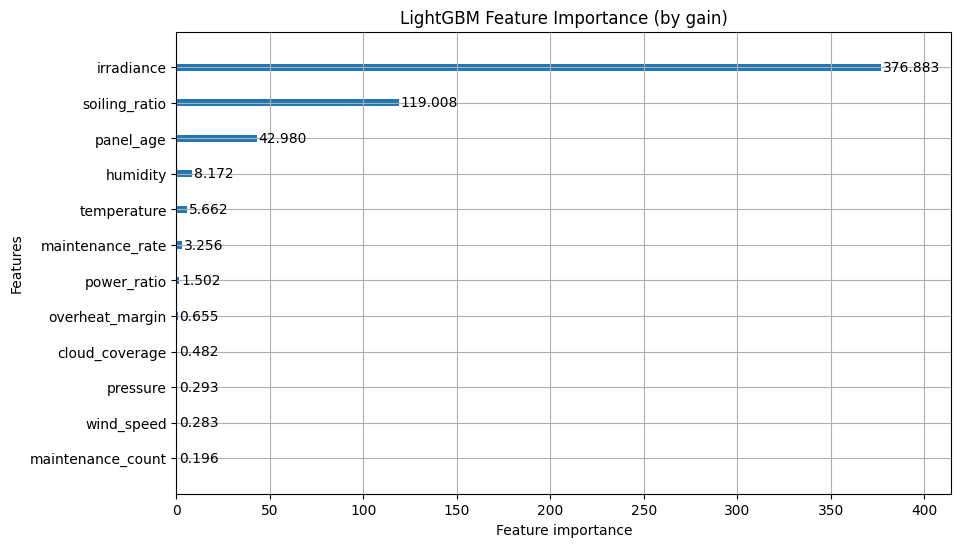

In [78]:
# LightGBM feature importance
best_params_lgb = study_lgb.best_params

# Import the early_stopping callback
from lightgbm.callback import early_stopping

model_lgb = lgb.train(
    best_params_lgb,
    train_data,
    valid_sets=[val_data],
    num_boost_round=1000,
    # Use the early_stopping callback instead of early_stopping_rounds
    callbacks=[early_stopping(stopping_rounds=50, verbose=100)]
)

# After training your model (e.g., 'model' from lgb.train)
lgb.plot_importance(model_lgb, max_num_features=20, importance_type='gain', figsize=(10,6))
plt.title("LightGBM Feature Importance (by gain)")
plt.show()

In [79]:
def objective_cat(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 0.0, 1.0),
    }

    model = CatBoostRegressor(
        **params,
        verbose=0,
        random_state=42,
        loss_function="RMSE"
    )

    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_t, X_v = X.iloc[train_idx], X.iloc[val_idx]
        y_t, y_v = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_t, y_t)
        preds = model.predict(X_v)
        score = custom_score(y_v, preds)
        scores.append(score)

    return -np.mean(scores)  # Minimize the negative custom score

study = optuna.create_study(direction="minimize")
study.optimize(objective_cat, n_trials=50)

print("Best parameters:", study.best_params)
print("Best custom score:", -study.best_value)

best_params_cat = study.best_params

[I 2025-06-03 08:09:23,350] A new study created in memory with name: no-name-55b306e2-8196-4f37-97be-89e98329ba6c
[I 2025-06-03 08:09:28,794] Trial 0 finished with value: -89.57721729187631 and parameters: {'iterations': 606, 'depth': 5, 'learning_rate': 0.09793366637276839, 'l2_leaf_reg': 7.161230451521375, 'bagging_temperature': 0.5033962437006507, 'border_count': 75, 'random_strength': 0.06180471457806158}. Best is trial 0 with value: -89.57721729187631.
[I 2025-06-03 08:09:37,230] Trial 1 finished with value: -89.30126312653518 and parameters: {'iterations': 890, 'depth': 3, 'learning_rate': 0.27542762662902004, 'l2_leaf_reg': 8.672541566604218, 'bagging_temperature': 0.10943300097309772, 'border_count': 91, 'random_strength': 0.20525759388256548}. Best is trial 0 with value: -89.57721729187631.
[I 2025-06-03 08:10:06,296] Trial 2 finished with value: -89.64429835401126 and parameters: {'iterations': 133, 'depth': 11, 'learning_rate': 0.03469092514394745, 'l2_leaf_reg': 2.138156668

Best parameters: {'iterations': 593, 'depth': 5, 'learning_rate': 0.01110720785557236, 'l2_leaf_reg': 6.301345870023309, 'bagging_temperature': 0.6434537378335359, 'border_count': 184, 'random_strength': 0.3259893377594838}
Best custom score: 89.74401082217959


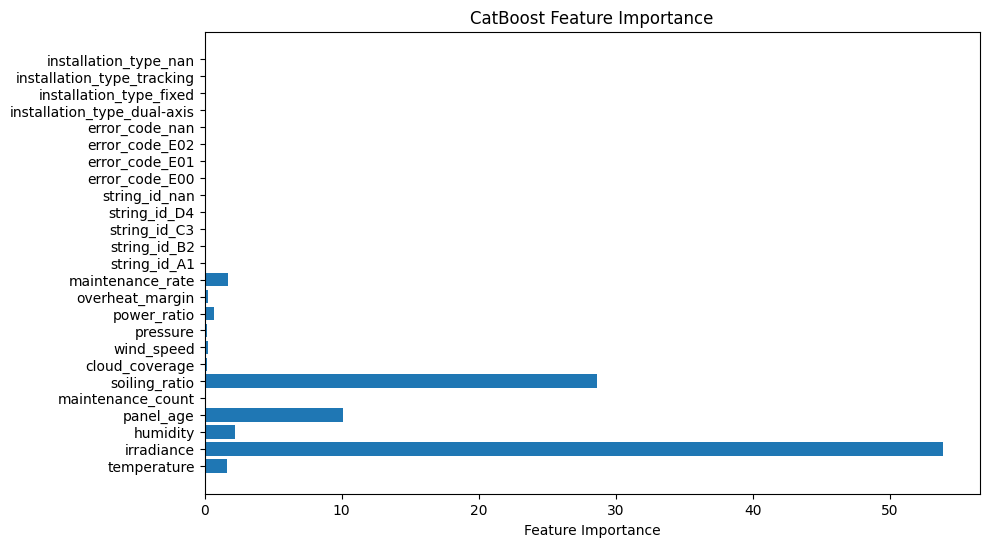

In [80]:
# Create the final model with best params
best_model_cat = CatBoostRegressor(
    **best_params_cat,
    random_seed=42,
    verbose=False
)

# Fit on full training data
best_model_cat.fit(X_train, y_train)

# Get feature importance
importance = best_model_cat.get_feature_importance()
feature_names = X_train.columns

# Plot
plt.figure(figsize=(10,6))
plt.barh(feature_names, importance)
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()

### As it can be seen the category columns are unnecessary for training
### We might try to delete them

In [83]:
# X.info()
# The unnecessary columns are boolean type.
X_no_obj = X.drop(columns=X.select_dtypes(include=['bool']).columns)
X_no_obj.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19813 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature        19813 non-null  float64
 1   irradiance         19813 non-null  float64
 2   humidity           19813 non-null  float64
 3   panel_age          19813 non-null  float64
 4   maintenance_count  19813 non-null  float64
 5   soiling_ratio      19813 non-null  float64
 6   cloud_coverage     19813 non-null  float64
 7   wind_speed         19813 non-null  float64
 8   pressure           19813 non-null  float64
 9   power_ratio        19813 non-null  float64
 10  overheat_margin    19813 non-null  float64
 11  maintenance_rate   19813 non-null  float64
dtypes: float64(12)
memory usage: 2.0 MB


In [87]:
X_no_obj_train, X_no_obj_val, y_train, y_val = train_test_split(X_no_obj, y, test_size=0.2)

In [103]:
def objective_cat(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "depth": trial.suggest_int("depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 0.0, 1.0),
    }

    model = CatBoostRegressor(
        **params,
        verbose=0,
        random_state=42,
        loss_function="RMSE"
    )

    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(X_no_obj_train):
        X_t, X_v = X_no_obj.iloc[train_idx], X_no_obj.iloc[val_idx]
        y_t, y_v = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_t, y_t)
        preds = model.predict(X_v)
        score = custom_score(y_v, preds)
        scores.append(score)

    return -np.mean(scores)  # Minimize the negative custom score

study = optuna.create_study(direction="minimize")
study.optimize(objective_cat, n_trials=50)

print("Best parameters:", study.best_params)
print("Best custom score:", -study.best_value)

best_params_cat = study.best_params

[I 2025-06-03 11:08:17,357] A new study created in memory with name: no-name-75eb3bfa-ca2b-4242-8229-9f4c52c93dfe
[I 2025-06-03 11:08:21,929] Trial 0 finished with value: -89.503750020567 and parameters: {'iterations': 368, 'depth': 3, 'learning_rate': 0.008542964008576322, 'l2_leaf_reg': 9.803314500245046, 'bagging_temperature': 0.782494406513371, 'border_count': 151, 'random_strength': 0.11844099719283141}. Best is trial 0 with value: -89.503750020567.
[I 2025-06-03 11:11:18,897] Trial 1 finished with value: -89.47398615997884 and parameters: {'iterations': 341, 'depth': 12, 'learning_rate': 0.09098116687457597, 'l2_leaf_reg': 7.990212959500521, 'bagging_temperature': 0.33207418471123373, 'border_count': 217, 'random_strength': 0.26376027831444293}. Best is trial 0 with value: -89.503750020567.
[I 2025-06-03 11:11:29,459] Trial 2 finished with value: -89.02239079476976 and parameters: {'iterations': 306, 'depth': 8, 'learning_rate': 0.2989086125802518, 'l2_leaf_reg': 3.25575802958850

KeyboardInterrupt: 

# 5. Test evaluation

In [89]:
test.head()

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,string_id,error_code,installation_type
0,0,17.618379,85.449838,90.81542277591531,13.910963,6.0,0.889765,6.370396,0.069101,19.517274,33.509889,7.1819582155525445,1034.782455188643,C3,E01,tracking
1,1,34.826323,722.801748,20.98299301574633,20.916528,4.0,0.590372,30.095867,1.713852,37.421443,32.327060,4.184581989921003,992.3197520437311,D4,E00,NaN
2,2,33.776934,485.491998,55.61404977577451,1.446962,3.0,0.611425,28.424430,1.696936,32.147763,69.613333,6.25944104775485,999.2134568588949,D4,E01,dual-axis
3,3,18.584189,350.022720,49.04476645510075,18.810133,5.0,NaN,7.848038,0.787188,25.734118,42.862760,2.7696074663593944,1026.6500782154521,C3,E02,dual-axis
4,4,43.044908,437.295622,8.761571340027164,NaN,8.0,0.564938,12.300717,1.867620,NaN,51.025763,11.846974043208318,1010.809942771749,B2,NaN,fixed


In [90]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  12000 non-null  int64  
 1   temperature         11418 non-null  float64
 2   irradiance          11385 non-null  float64
 3   humidity            12000 non-null  object 
 4   panel_age           11393 non-null  float64
 5   maintenance_count   11391 non-null  float64
 6   soiling_ratio       11390 non-null  float64
 7   voltage             11453 non-null  float64
 8   current             11413 non-null  float64
 9   module_temperature  11420 non-null  float64
 10  cloud_coverage      11418 non-null  float64
 11  wind_speed          12000 non-null  object 
 12  pressure            12000 non-null  object 
 13  string_id           12000 non-null  object 
 14  error_code          8389 non-null   object 
 15  installation_type   9021 non-null   object 
dtypes: f

In [91]:
# Let's change the data type of humidity, wind_speed and pressure columns, so we can operate with them as numeric
test['humidity'] = pd.to_numeric(test['humidity'], errors='coerce')
test['wind_speed'] = pd.to_numeric(test['wind_speed'], errors='coerce')
test['pressure'] = pd.to_numeric(test['pressure'], errors='coerce')

# Fill missing values in numeric columns with the mean
for col in numeric_columns:
    test[col].fillna(test[col].mean(), inplace=True)

# Verify that there are no more missing values in numeric columns
print(test[numeric_columns].isnull().sum())



temperature           0
irradiance            0
humidity              0
panel_age             0
maintenance_count     0
soiling_ratio         0
voltage               0
current               0
module_temperature    0
cloud_coverage        0
wind_speed            0
pressure              0
dtype: int64


<ipython-input-91-7d822b6bba40>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[col].fillna(test[col].mean(), inplace=True)


In [92]:
print(test.columns)

Index(['id', 'temperature', 'irradiance', 'humidity', 'panel_age',
       'maintenance_count', 'soiling_ratio', 'voltage', 'current',
       'module_temperature', 'cloud_coverage', 'wind_speed', 'pressure',
       'string_id', 'error_code', 'installation_type'],
      dtype='object')


In [93]:

test['effective_irradiance'] = test['irradiance'] - 1 - test['soiling_ratio']
test['power_ratio'] = test['current'] * test['voltage']
test['overheat_margin'] = test['module_temperature'] - test['temperature']
test['maintenance_rate'] = test['maintenance_count'] / test['panel_age']

test = test.drop(columns=['module_temperature', 'voltage', 'current', 'effective_irradiance'])

test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 12000 non-null  int64  
 1   temperature        12000 non-null  float64
 2   irradiance         12000 non-null  float64
 3   humidity           12000 non-null  float64
 4   panel_age          12000 non-null  float64
 5   maintenance_count  12000 non-null  float64
 6   soiling_ratio      12000 non-null  float64
 7   cloud_coverage     12000 non-null  float64
 8   wind_speed         12000 non-null  float64
 9   pressure           12000 non-null  float64
 10  string_id          12000 non-null  object 
 11  error_code         8389 non-null   object 
 12  installation_type  9021 non-null   object 
 13  power_ratio        12000 non-null  float64
 14  overheat_margin    12000 non-null  float64
 15  maintenance_rate   12000 non-null  float64
dtypes: float64(12), int64(

In [94]:
test = test.drop(columns=['string_id', 'error_code', 'installation_type'])

In [95]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 12000 non-null  int64  
 1   temperature        12000 non-null  float64
 2   irradiance         12000 non-null  float64
 3   humidity           12000 non-null  float64
 4   panel_age          12000 non-null  float64
 5   maintenance_count  12000 non-null  float64
 6   soiling_ratio      12000 non-null  float64
 7   cloud_coverage     12000 non-null  float64
 8   wind_speed         12000 non-null  float64
 9   pressure           12000 non-null  float64
 10  power_ratio        12000 non-null  float64
 11  overheat_margin    12000 non-null  float64
 12  maintenance_rate   12000 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.2 MB


In [96]:
test = test.drop(columns=['id'])

In [104]:
# Create the final model with best params
best_model_cat = CatBoostRegressor(
    **best_params_cat,
    random_seed=42,
    verbose=False
)

# Fit on full training data
best_model_cat.fit(X_no_obj_train, y_train)


predictions = best_model_cat.predict(test)

In [99]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature        12000 non-null  float64
 1   irradiance         12000 non-null  float64
 2   humidity           12000 non-null  float64
 3   panel_age          12000 non-null  float64
 4   maintenance_count  12000 non-null  float64
 5   soiling_ratio      12000 non-null  float64
 6   cloud_coverage     12000 non-null  float64
 7   wind_speed         12000 non-null  float64
 8   pressure           12000 non-null  float64
 9   power_ratio        12000 non-null  float64
 10  overheat_margin    12000 non-null  float64
 11  maintenance_rate   12000 non-null  float64
dtypes: float64(12)
memory usage: 1.1 MB


In [100]:
X_no_obj.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19813 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   temperature        19813 non-null  float64
 1   irradiance         19813 non-null  float64
 2   humidity           19813 non-null  float64
 3   panel_age          19813 non-null  float64
 4   maintenance_count  19813 non-null  float64
 5   soiling_ratio      19813 non-null  float64
 6   cloud_coverage     19813 non-null  float64
 7   wind_speed         19813 non-null  float64
 8   pressure           19813 non-null  float64
 9   power_ratio        19813 non-null  float64
 10  overheat_margin    19813 non-null  float64
 11  maintenance_rate   19813 non-null  float64
dtypes: float64(12)
memory usage: 2.0 MB


In [102]:
X_no_obj.shape

(19813, 12)

In [105]:
test_id = pd.read_csv(file_path_test)

In [106]:
id_column = test_id['id']

In [107]:
submission = pd.DataFrame({'id': id_column, 'efficiency': predictions})

In [110]:
subm.to_csv("submission_tmmd.csv")

In [109]:
# Assuming your DataFrame is named 'df' and has an 'id' column
# Replace 'df' with the actual name of your DataFrame

# Set 'id' column as the index
subm = submission.set_index('id')

# Display the first few rows to verify
print(submission.head())
print(subm.head())

   id  efficiency
0   0    0.396904
1   1    0.537371
2   2    0.515877
3   3    0.462000
4   4    0.463759
    efficiency
id            
0     0.396904
1     0.537371
2     0.515877
3     0.462000
4     0.463759
